
# <font  color='blue'> Neurasmus 2025, Network motifs, a link between  structure and function in neural networks  <font>

Network structure is important.  Throughout the week, you  investigate properties of graphs and neural networks.

Here, we simulate neural activity on some of these networks.

As is often the case in nature,  there is a strong link between structure and function.

A motif in neural netwokrs is a pattern of connections with a frequence of occurence that significantly exceeds expections.

*Sporns O, Kötter R. Motifs in brain networks. PLoS Biol. 2004 Nov;2(11)*

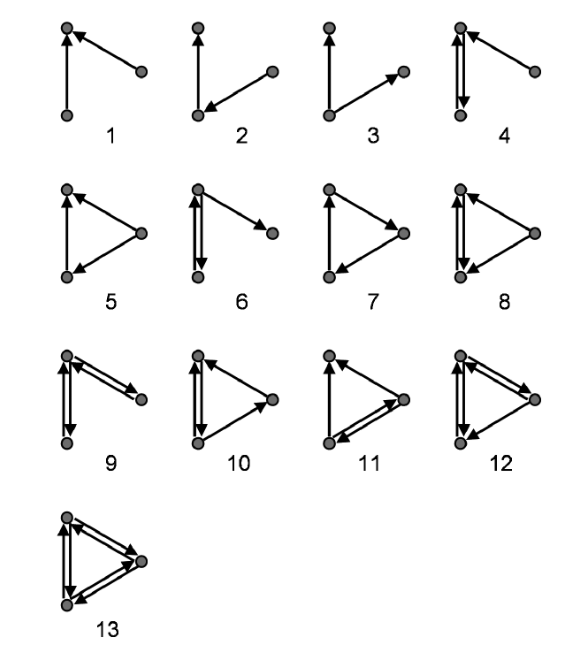

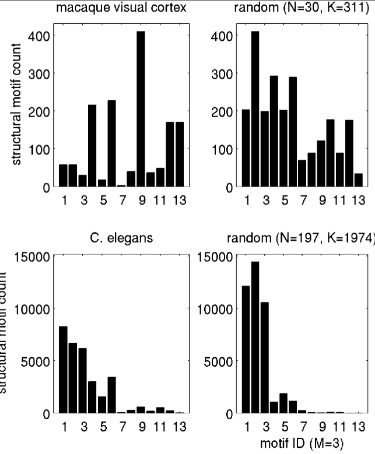

The overrepresentation of some motifs in neural networks occurs accros species.  

We will investigate two examples of simple network motifs in the zebrafish.

-In the first example, we investigate the importance of contra lateral inhibition in sensory input processing and decision making.

-In the second example, we look at how information is tranformed in a feedforward network.

##  <font  color='brown'> Contralateral inhibition <font>

In many systems, (auditory, visual) sensory input is received in a bilateral manner.

Often, there are contralateral connections so that the input on one side impacts the perception on the other side.

In the first example, we investigate contralateral inhibition, that is the input on one side inhibits the response on the other side which can leading to a 'winner takes it all' behaviour.

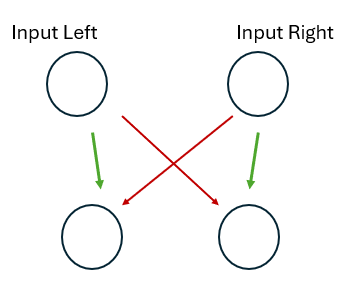

Let's begin with a toy example.

In [ ]:
import math
import ipywidgets as widgets

def sig(x):
  #computes a sigmoid function
  #INPUT: x a real number
  #OUTPUT: sigma, a real number, the value of the sigmoid function
  sigma=1/(1+math.exp(-x))
  return sigma

def ContraInh(InpLeft, InpRight):
  #computes the response of a toy model with contralateral inhibition
  #INPUT, InpLeft, InpRigh, real numbers, the strength of inputs
  #OUTPUT, SensL, SensR, real numbers, the activity of left and right sensor neurons
  #OUTPUT, respLeft, respRight, real numbers the active of left and right response neurons
  SensL=sig(2*(InpLeft-1))
  SensR=sig(2*(InpRight-1))
  respLeft=sig(10*(SensL-SensR))
  respRight=sig(10*(SensR-SensL))
  return SensL, SensR,respLeft, respRight

In [ ]:
def print_ContraInh(InpLeft,InpRight):
  #prints the output of the ContraInh function
  #INPUT, InpLeft, InpRigh, real numbers, the strength of inputs
  SensL, SensR, respLeft, respRight=ContraInh(InpLeft,InpRight)
  print('Sensory Left',SensL)
  print('Sensory Right', SensR)
  print('Response Left',respLeft)
  print('Response Right',respRight)

In [ ]:
widgets.interact(print_ContraInh,InpLeft=(0,2,0.1),InpRight=(0,2,0.1))

interactive(children=(FloatSlider(value=1.0, description='InpLeft', max=2.0), FloatSlider(value=1.0, descripti…

<function __main__.print_ContraInh(InpLeft, InpRight)>

A slight difference in lateral input strength leads to a big ratio in the response strength.

We illustrate this with a matrix display

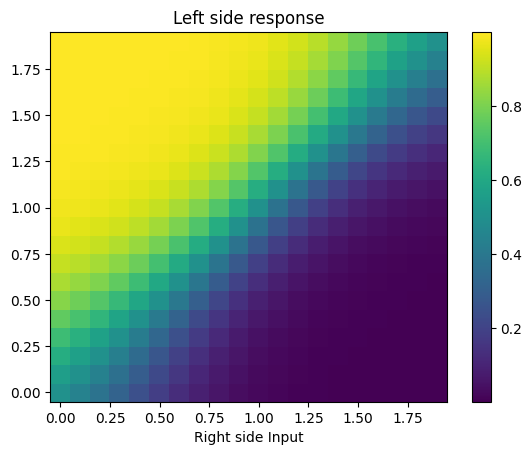

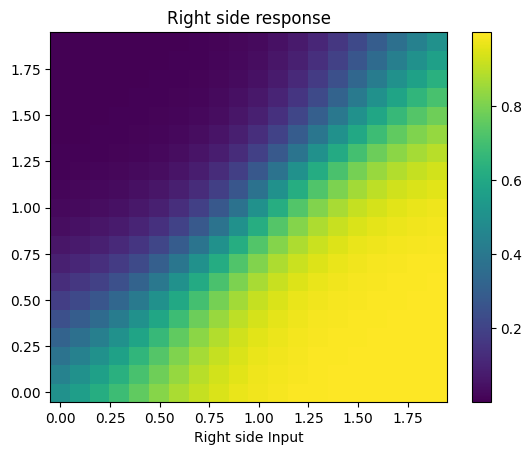

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

resp_left=np.zeros((20,20))
resp_right=np.zeros((20,20))
InpL=np.zeros(20)
InpR=np.zeros(20)
for j in range(20):
  InpL[j]=0.1*j
  for k in range(20):
    InpR[k]=0.1*k
    SensL, SensR,respLeft, respRight=ContraInh(InpL[j],InpR[k])
    resp_left[j,k]=respLeft
    resp_right[j,k]=respRight

plt.pcolor(InpR,InpL,resp_left)
plt.colorbar()
plt.title('Left side response')
plt.xlabel('Right side Input')
plt.xlabel('Right side Input')
plt.show()

plt.pcolor(InpR,InpL,resp_right)
plt.colorbar()
plt.title('Right side response')
plt.xlabel('Right side Input')
plt.xlabel('Right side Input')
plt.show()


## <font  color='brown'> A Model of Neural Activity for decision making  <font>

We now investigate a model of  a neural network  invovled in decision making of the zebrafish.

This model will involve the principle of contra lateral inhibition just presented.

We reproduce the model given in **A circuit motif in the zebrafish hindbrain for a two alternative behavioral choice to turn left or right** by Koyuma et al.

This model uses a mixture of different formalisms. Most neurons are described by **LIF equations** while auditory cells are described by the more complex Hodgkin-Huxley equations.

The model also describes synaptic connections between individual neurons as well as gap junctions.



On the biological side, the model describes the neural circuit leading to the decision to turn left or right given an auditory input. The authors argue the this is a primitive circuit and that an equivalent could be found across several species.

There are three types of neurons in the model:
- The **auditory neurons** (VIII ganglion) that receive an external stimulus,
-The **feed forward neurons** (FF) receive input through gap junctions from the auditory neurons. The FF neurons send inhibitory connection to contralateral FF neurons and to Mauthner cells,
-The** Mauthner cells **receive excitatory inputs from auditory cells and transmit it to motor regions. Mauthner cells are much larger than FF cells leading to a smaller electrical resistance.


Intuitively, a stimulus from one side will excite the ipsilateral Mauthner cell an indirectly inhibit the contraletaral Mauthner cell.  This helps select a single direction.

Another important feature of the model is the presence of gap junctions.  When two neurons are connected by a gap junction, we cannot model the activity of the presynaptic neurons with a LIF formalism as it doesn't describe the membrane potential during a spike.

For this reason auditory cells are described with a Hodgkin-Huxley formalism. Other cells are described by the simpler LIF formalism.


**An illustration of the network of interest**

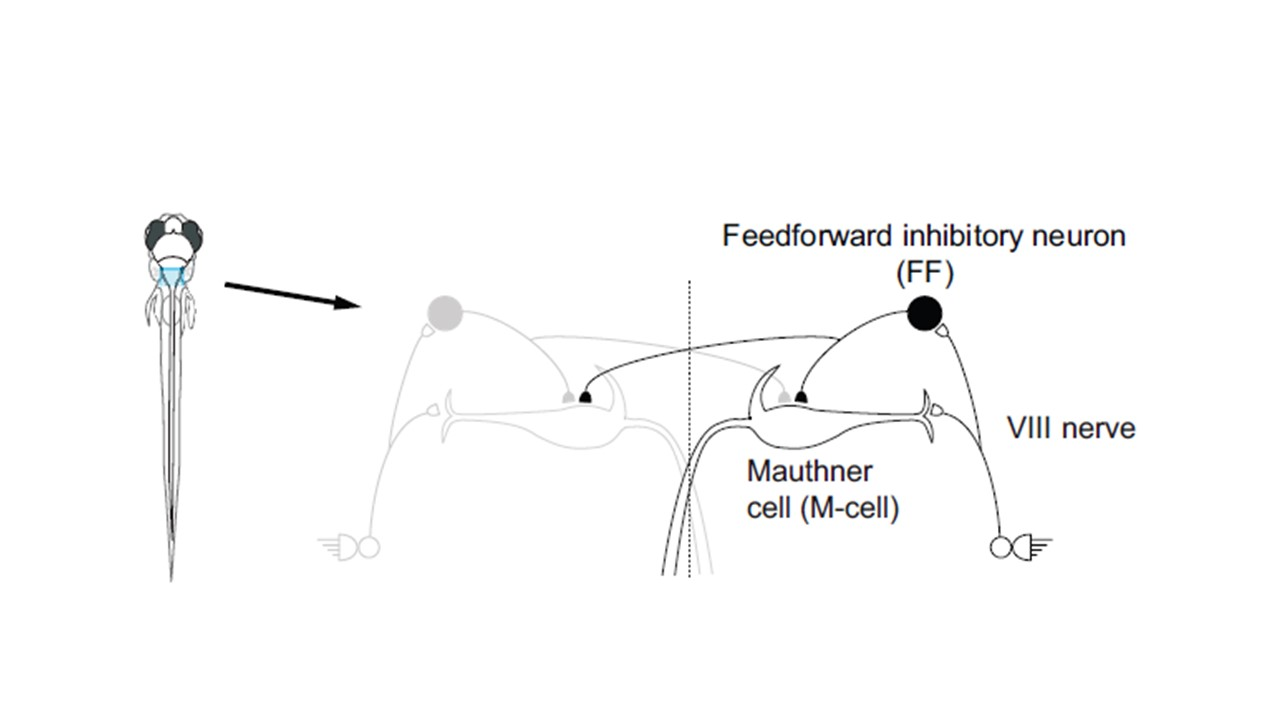

**An ingeneer schematic of the model**

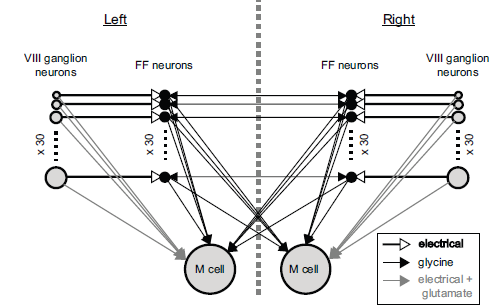

**An illustration of a gap junction** from wikipedia

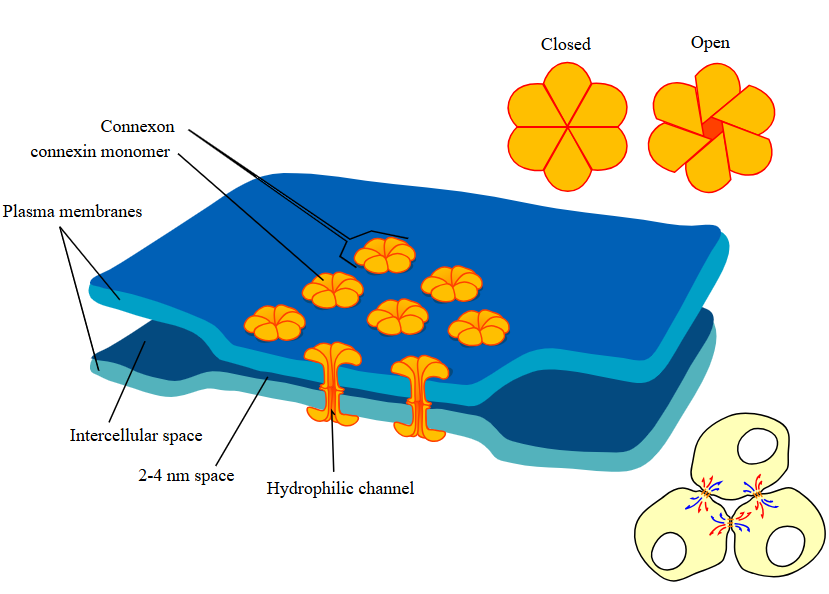

The paper describing this model provides a good example of a model that is validated by experimental data and sheds light on fundamental principles.

On the weaker side, the authors don't provide a complete list of their equations or access to a code.

One could ask: 'what is the role of feedforward inhibitory neurons?'

They are not necessary to transmit the input from the nerve to the M cell.

### **The Leaky Integrate and Fire (LIF) model for the FF neurons and M cells**

We start by importing the relevant libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

We define a class of parameters for LIF neurons.

In [ ]:
#Parameters for the LIF FF cells
class param_LIF:
  def __init__(self, Rm,Erest,ECl,Espike,tau):
    self.Rm = Rm
    self.Erest = Erest
    self.ECl= ECl
    self.Espike=Espike
    self.tau=tau

**Rm** stands for the membrane resistance of the membrane,

**Erest** represents the membrane potential of the cell when it is at rest,

**ECl** is the reversal potential of chloride currents.  The more hyperpolarized, the stronger the inhbition

**Espike** stands for the value of membrane potential at which spiking occur,

**tau** is time constant of neural response.

We specify these parameters for feedforward inhibitory neurons as well as for Mathner cells. Remark the while cells from different populations can be described by the same formalism, parameters should differ from one population to another.

In [ ]:

param_ff = param_LIF(400,-77,-75,-61,10)
param_M=param_LIF(10,-79,-75,-61,10)


**We observe a notable difference:**  The *membrane resistance* is much larger for feedforwad neurons than for Mauthner cells.

This is consistent with the fact that Mauthner cells are drawn much larger in the above schematic.

As our model will include both HH neurons and LIF neurons which are discontinuous, it is impractical to use differential equations.

We will divide the time span of the simulations into discrete time steps.

We define a parameter class for the simulation duration and time step.

In [ ]:
class param_Simul:
  def __init__(self,Dur,dt,Nstep):
    self.Dur = Dur
    self.dt = dt
    self.Nstep= Nstep

Dur=200
dt=0.002
Nstep=int(Dur/dt)
param_S = param_Simul(Dur,dt,Nstep)

We are now ready to define functions specifying the LIF model

In [ ]:
def LIF_pot(V,I,param,param_S):
  #This function updates the membrane potential during a single time step
  #and decides if a spike occurs.
  #INPUT, V, the membrane potential,
  #INPUT, I, the current injected into the model,
  #INPUT, param the parameter of the LIF cell,
  #INTPUT, param_S the parameters of the simulation,
  #OUTPUT, Vnew, the new value of the membrane potential,
  #OUTPUT, is_spike, 1 if there is a spike during the time step, 0 otherwise
  is_spike=0
  Vnew=V+param_S.dt*((param_ff.Erest-V)/param.tau)+(param_S.dt*param.Rm*I/param.tau)
  if Vnew>param.Espike:
    Vnew=param.Erest
    is_spike=1
  return Vnew,is_spike

def LIF_Sim(Vinit,I,param,param_S):
  #This function computes the temporal response of membrane potential
  #and the spike train of a LIF neuron.
  #INPUT, Vinit, the initial value of the membrane potential potential,
  #INPUT, I, the current injected into the cell,
  #INPUT, param, parameters of the LIF model,
  #INPUT, param_S, simulation parameters.
  V_vec=np.zeros(param_S.Nstep)
  Spike_vec=np.zeros(param_S.Nstep)
  Time_vec=np.zeros(param_S.Nstep)
  V_vec[0]=Vinit
  for i in range(param_S.Nstep-1):
    V_vec[i+1],Spike_vec[i+1]=LIF_pot(V_vec[i],I,param,param_S)
    Time_vec[i+1]=Time_vec[i]+param_S.dt
  return V_vec,Spike_vec,Time_vec


We now now run a first example of the responses of FF and M cells.  In this example, we inject a constant current of I=0.008 in each cell.  
It is sufficient to trigger a response in the FF neurons but not in M cells

In [ ]:
def plot_LIF_MFF(Iinj,opt):
  #This functions plots the result of the LIF model for the M and FF cells
  #INPUT: Iinj, a real number, the input to the model
  #INPUT:opt, 0,1, decides whether the spike train or membrane potential is plotted
  V_vec_ff,Spike_vec_ff,Time_vec=LIF_Sim(-65,Iinj,param_ff,param_S)
  V_vec_M,Spike_vec_M,Time_vec=LIF_Sim(-65,Iinj,param_M,param_S)
  if opt==1:
    plt.plot(Time_vec,V_vec_ff,Time_vec,V_vec_M)
    plt.xlim(0,100)
    plt.title('Membrane potential I=' + str(Iinj))
    plt.ylabel('Membrane potential (mV)')
    plt.xlabel('Time (ms)')
    plt.legend(['ff', 'M'])
    plt.show()

  else:
    for j in range(len(Spike_vec_M)):
      Spike_vec_M[j]=2*Spike_vec_M[j]
    plt.plot(Time_vec,Spike_vec_ff,'.',Time_vec,Spike_vec_M,'.')
    plt.ylim(0.5, 2.5)
    plt.yticks([])
    plt.xlim(0,100)
    plt.title('spike trains I=' +str(Iinj))
    plt.xlabel('Time (ms)')
    plt.legend(['ff', 'M'])
    plt.show()

In [ ]:
widgets.interact( plot_LIF_MFF,Iinj=(0,2,0.001),opt=(1,2))

interactive(children=(FloatSlider(value=1.0, description='Iinj', max=2.0, step=0.001), IntSlider(value=1, desc…

<function __main__.plot_LIF_MFF(Iinj, opt)>

Due to the difference in *membrane resistance* 10 vs 400, the Mauthner cell needs a much larger current to trigger action potentials.
We relaunch the simulations with a larger current of $I=2$.  Now both cells respond an the FF cells spikes at a very high frequency

Due to the high frequency of the FF cell response, we can't see individual spikes.

We can also compute the input-firing frequency response of each cell type.

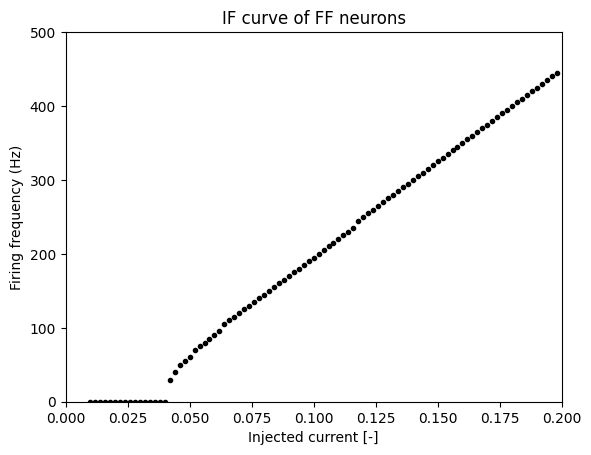

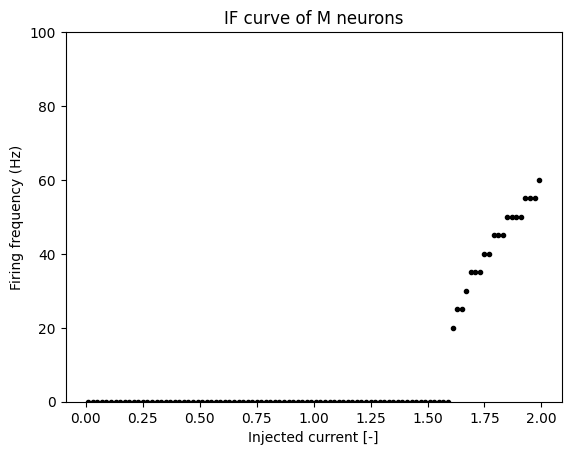

In [ ]:
I_vec_ff=np.arange(0.01,0.2,0.002)
I_vec_M=np.arange(0.01,2,0.02)

Freq_vec_ff=[]
for j in I_vec_ff:
  V_vec_ff,Spike_vec_ff,Time_vec=LIF_Sim(-65,j,param_ff,param_S)
  freq_ff=0
  for k in  Spike_vec_ff:
    freq_ff=freq_ff+k
  freq_ff=freq_ff/param_S.Dur
  Freq_vec_ff.append(1000*freq_ff)



Freq_vec_M=[]
for j in I_vec_M:
  V_vec_M,Spike_vec_M,Time_vec=LIF_Sim(-65,j,param_M,param_S)
  freq_M=0
  for k in  Spike_vec_M:
    freq_M=freq_M+k
  freq_M=freq_M/param_S.Dur
  Freq_vec_M.append(1000*freq_M)


plt.plot(I_vec_ff,Freq_vec_ff,'.k')
plt.xlabel('Injected current [-]')
plt.ylabel('Firing frequency (Hz)')
plt.xlim(0,0.2)
plt.ylim(0, 500)
plt.title('IF curve of FF neurons')
plt.show()

plt.plot(I_vec_M,Freq_vec_M,'.k')
plt.xlabel('Injected current [-]')
plt.ylabel('Firing frequency (Hz)')
plt.title('IF curve of M neurons')
plt.ylim(0, 100)
plt.show()


### The Hodgkin-Huxley model for VIII ganglion cells

We now move to define the Hodgkin-Huxley model that will be used the describe the activity of auditory cells.  

An advantage of the HH model is that it provides an explicit description of the membrane potential during a spike.  

 This is essential in our model as we want to describe currents through gap junctions.

 As a downside, it requires four dynamical variables to describe action potentials.

A schematic of the Hodgkin-Huxley model from de Burgt et al. DOI:10.1557/mrs.2020.194

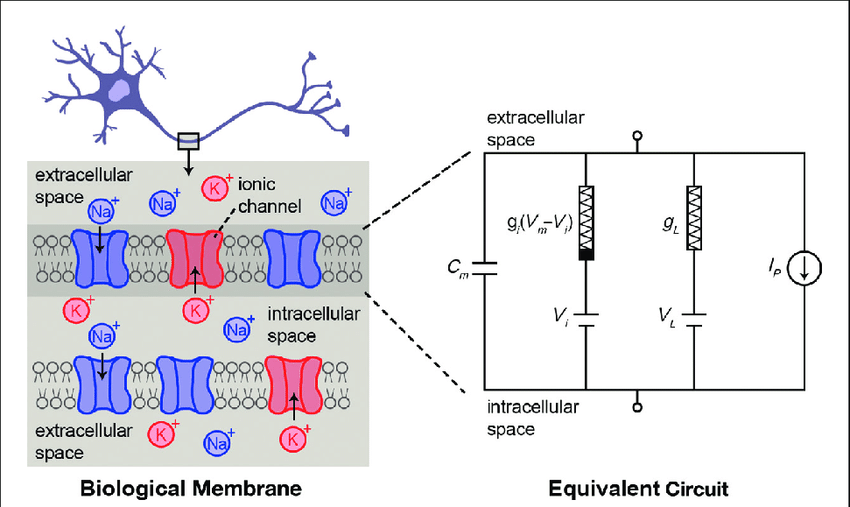

We define a parameter class for Hodgkin-Huxley models.

In [ ]:
class param_HH:
  def __init__(self, EL,EK,ENa,gL,gNa,gK,SA):
    self.EL = EL
    self.EK = EK
    self.ENa= ENa
    self.gL=gL
    self.gNa=gNa
    self.gK=gK
    self.SA=SA

#Parmaters for HH auditory cell
El_A=-79
EK_A=-90
ENa_A=50
gl_A=0.3
gNa_A=120
gK_A=36
SA_A=2000 #20000

param_Aud = param_HH(El_A,EK_A,ENa_A,gl_A,gNa_A,gK_A,SA_A)


In addition of synaptic currents, three types of transmembrane currents are described in the HH model.  *Leak currents*, *sodium mediated excitatory currents* and *potassium mediated inhibitory current*.

The parameters of the model are

**EL** The reversal potential of leak channels,

**EK** The reversal potentieal of potassium channels,

**ENa** The reversal potential of sodium channels,

**gl** The conductance of leak channels.

**gNa** The maximal conductance of sodium channels,

**gK** The maximal conductance of potassium channels.

While the conductance of *leak channels* remains constant, the conductance of sodium and potassium channels are determined by the opening and closing of voltage dependant gates.

We now define the auxiliairy functions involved in the opening and closing of these gates.

The form of these equations are standard but were not explicitly given in the paper. ☹

Look at the shape of the equations, what could be a problem?  There can be an 'artificial' division by zeros when both the numerator and denominator are equal to zero.  We handle this with an 'if'.

In [ ]:
def alpha_m(V):
  #Opening rate of m gates.
  #INPUT, V, membrane potential,
  #OUTPUT, aplpha, opening rate.
  if abs(V+40)>0.01:
    alpha=0.1*(V+40)/(1-math.exp(-(V+40)/10))
  else:
    alpha=1
  return alpha

def beta_m(V):
  #closing rate of m gates.
  #INPUT, V, membrane potential,
  #OUTPUT, beta, closing rate.
  beta=4*math.exp(-(V+65)/18)
  return beta

def alpha_h(V):
  #opening rate of h gates.
  #INPUT, V, membrane potential,
  #OUTPUT, alpha, opening rate.
  alpha=0.07*math.exp(-(V+65)/20)
  return alpha

def beta_h(V):
  #closing rate of h gates.
  #INPUT, V, membrane potential,
  #OUTPUT, beta, closing rate.
  beta=1/(1+math.exp(-(V+35)/10))
  return beta

def alpha_n(V):
  #opening rate of n gates.
  #INPUT, V, membrane potential,
  #OUTPUT, alpha, opening rate.
  if abs(V+45)>0.01:
    alpha=.01 * ((-45-V) / (np.exp((-45-V)/5)-1))
  else:
    alpha=.05
  return alpha

def beta_n(V):
  #closing rate of n gates
  #INPUT V, membrane potential
  #OUTPUT, beta, closing rate
  beta=0.125*math.exp(-(V+35)/40)
  return beta

def m_inf(V):
  #equilibrum value of m gates
  #INPUT V, membrane potential
  #OUTPUT, m_inf, equilibrium value
  m_inf=alpha_m(V)/(alpha_m(V)+beta_m(V))
  return m_inf

def h_inf(V):
  #equilibrium value of h gates,
  #INPUT V, membrane potential
  #OUTPUT, h_inf, equilibrium value
  h_inf=alpha_h(V)/(alpha_h(V)+beta_h(V))
  return h_inf

def n_inf(V):
  #equilibrium value of n gates
  #INPUT v, membrane potential
  #OUTPUT, n_inf, equilibrium value
  n_inf=alpha_n(V)/(alpha_n(V)+beta_n(V))
  return n_inf

def tau_m(V):
  #time constant of m gates
  #INPUT V, membrane potential
  #OUTPUT tau_m, time constant
  tau_m=1/(alpha_m(V)+beta_m(V))
  return tau_m

def tau_h(V):
  #time constant of h gates
  #INPUT V, membrane potential
  #OUTPUT, tau_h, time constant
  tau_h=1/(alpha_h(V)+beta_h(V))
  return tau_h

def tau_n(V):
  #Time constant of n gates
  #INPUT V, membrane potential
  #OUTPUT, tau_n time constant
  tau_n=1/(alpha_n(V)+beta_n(V))
  return tau_n


We will now test and illustrate these auxiliary functions.

We will plot the equilibrium values and the time constant as a function of membrane potential.

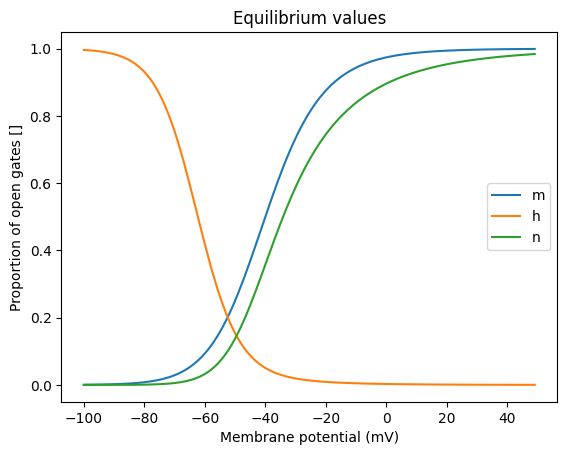

In [ ]:
V_Vec=[]
m_Vec=[]
h_Vec=[]
n_Vec=[]
tau_m_Vec=[]
tau_h_Vec=[]
tau_n_Vec=[]
for j in range(-100,50):
  V_Vec.append(j)
  m_Vec.append(m_inf(j))
  h_Vec.append(h_inf(j))
  n_Vec.append(n_inf(j))
  tau_m_Vec.append(tau_m(j))
  tau_h_Vec.append(tau_h(j))
  tau_n_Vec.append(tau_n(j))

plt.plot(V_Vec,m_Vec,V_Vec,h_Vec,V_Vec,n_Vec)
plt.ylabel('Proportion of open gates []')
plt.title('Equilibrium values')
plt.xlabel('Membrane potential (mV)')
plt.legend(['m','h','n'])
plt.show()

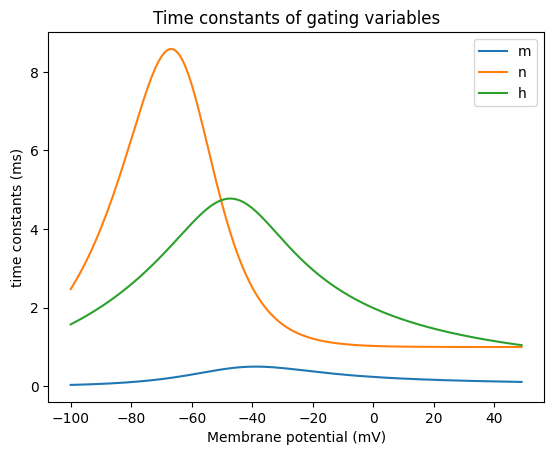

In [ ]:
plt.plot(V_Vec,tau_m_Vec,V_Vec,tau_h_Vec,V_Vec,tau_n_Vec)
plt.ylabel('time constants (ms)')
plt.title('Time constants of gating variables')
plt.xlabel('Membrane potential (mV)')
plt.legend(['m','n','h'])
plt.show()

From the first figure, we see that *m* and *n* gates open when the membrane depolarizes while we observe the opposite for the *h* gate.

In the second figure, we see that the dynamics of the *m* gate are much faster than the dynamics of the *h* and *n* gates.   This justifies the often made assumption the the *m* gate is always at equilibrium.

We now define the main function of the HH model.

Again, this is standard but the equations were not given in the paper.

In [ ]:
def HH_main(V,m,n,h,param,I):
  #This function returns the derivates of the variables in a HH model
  #INPUT V, m,n,h the current state of the model
  #INPUT I, external injected current
  #INPUT param, the parameter of the model
  #OUTPUT dV, dm, dn, dh, the rate of change of the variables
  IL=param.gL*(param.EL-V)
  INa=param.gNa*m*m*m*h*(param.ENa-V)
  IK=param.gK*n*n*n*(param.EK-V)
  dV=(IL+INa+IK+I)
  dm=(alpha_m(V)*(1-m)-beta_m(V)*m)
  dn=(alpha_n(V)*(1-n)-beta_n(V)*n)
  dh=(alpha_h(V)*(1-h)-beta_h(V)*h)
  return dV, dm, dn, dh

def HH_Sim(Vinit,param,param_S,I):
#This function computes the temporal response of a HH cell given a sinusoidal input
#INPUT Vinit, initial value of the simulation
#INPUT param, parameters of the HH cell
#INPUT param of the simulation
#INPUT I amplitude of the injected current
#INPUT freq, frequency of the injected current
#OUTPUT Time_vec, vector containing  the time points of the response
#OUTPUT V_vec, n_vec,m_vec,h_vec, vectors containing the responses of the variables
  V_vec=np.zeros(param_S.Nstep)
  m_vec=np.zeros(param_S.Nstep)
  n_vec=np.zeros(param_S.Nstep)
  h_vec=np.zeros(param_S.Nstep)
  Time_vec=np.zeros(param_S.Nstep)
  V_vec[0]=Vinit
  for i in range(param_S.Nstep-1):
    Iinj=I
    dV, dm, dn, dh=HH_main(V_vec[i],m_vec[i],n_vec[i],h_vec[i],param,Iinj)
    V_vec[i+1]=V_vec[i]+param_S.dt*dV
    m_vec[i+1]=m_vec[i]+param_S.dt*dm
    n_vec[i+1]=n_vec[i]+param_S.dt*dn
    h_vec[i+1]=h_vec[i]+param_S.dt*dh
    Time_vec[i+1]=Time_vec[i]+param_S.dt
  return V_vec,Time_vec,n_vec,m_vec,h_vec

We now run the HH model.  


In [ ]:
def plot_HH_Aus(Iinj):
  #This function plots the outcome of the HH model
  #INPUT: Iinj, a real number, the current injected in the HH model
  V_vec,Time_vec,n_vec,m_vec,h_vec=HH_Sim(-65,param_Aud,param_S,Iinj)
  plt.plot(Time_vec,V_vec)
  plt.xlim(0,200)
  plt.xlabel('Time (ms)')
  plt.ylabel('Membrane potential(mV)')
  plt.ylim(-90,40)
  plt.title('Iinj='+str(Iinj))
  plt.show()

In [ ]:
widgets.interact(plot_HH_Aus,Iinj=(0,200,0.1))

interactive(children=(FloatSlider(value=100.0, description='Iinj', max=200.0), Output()), _dom_classes=('widge…

<function __main__.plot_HH_Aus(Iinj)>

❓**Question:** What are the values of injected current for which we observe transitions ❓

We can also compute the input ▶ frequency response function of the HH model.

In [ ]:
def freq(V_vec,time_vec):
#This function compute the mean firing frequency from the membrane potential response of the cell
#INPUT, time_vec, a vector containing the time points of the response
#INPUT, V_vec, a vector containing the value of the membrane potential response
#OUTPUT, a real number, the mean spiking frequency
  spike_count=0
  for t in range(len(time_vec)-1):
    if V_vec[t+1]>0:
      if V_vec[t]<0:
        spike_count=spike_count+1
  return 1000*spike_count/time_vec[-1]



We sweep over an array of input values to obtain the input ▶ output graph

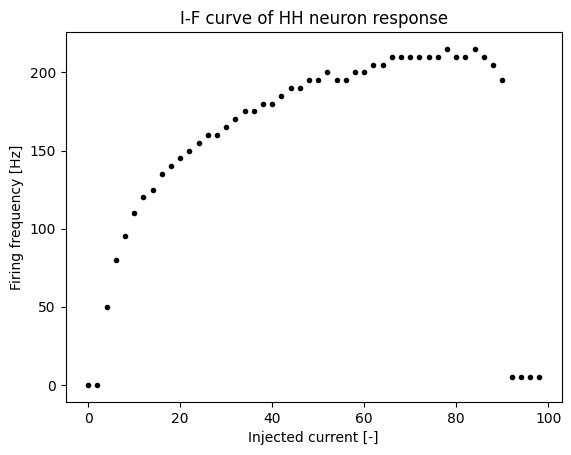

In [ ]:
I_vec=np.arange(0,100,2)
f_vec=[]
for j in I_vec:
  V_vec,Time_vec,n_vec,m_vec,h_vec=HH_Sim(-65,param_Aud,param_S,j)
  f_vec.append(freq(V_vec,Time_vec))

#We generate the figure
plt.plot(I_vec,f_vec,'.k')
plt.xlabel('Injected current [-]')
plt.ylabel('Firing frequency [Hz]')
plt.title('I-F curve of HH neuron response')
plt.show()

Contrary the the LIF model, the spiking frequency reaches an upper limit and the spiking stops when too much current is injected into the cell.

###Gap junction between auditory neurons and feed forward neurons


In the model, as in the zebrafish, auditory cells are connected one to one to ipsilateral feed forward neurons.

The activity of the auditory cells can thus drive the activity of FF neurons.

We write a small script with one auditory neuron receiving a constant input connected through a gap junction to a FF neuron.  We compute the spiking response of the FF cell.

In [ ]:
def Sim_AudFF(VinitAud,VinitFF,param_Aud,param_FF,param_S,I):
  #This function computes the membrane potential of a coupled system of an auditory and  aFF neuron,
  #An external input is applied to the auditory neuron which is connected through a gap junction to the FF neuron.
  #INPUT VinitAud,  a real number, the initial membrane potential of the auditory neuron
  #INPUT VinitFF, a real number, the initial membrane potential of the ff neuron
  #INPUT param_Aud, the parameters defining the auditory neuron
  #INPUT param_FF, the parameters defining the FF cell
  #OUTPUT V_vec_HH, a list, the membrane potential response of the auditory cell
  #OUTPT V_vec_FF, a list, the membrane potential of the feedforwad neuron
  #OUTPUT Spike_vec_FF, a list, the spike train of the FF neuron
  V_vec_HH=np.zeros(param_S.Nstep)
  V_vec_FF=np.zeros(param_S.Nstep)
  Spike_vec_FF=np.zeros(param_S.Nstep)
  Time_vec=np.zeros(param_S.Nstep)
  m_vec_HH=np.zeros(param_S.Nstep)
  n_vec_HH=np.zeros(param_S.Nstep)
  h_vec_HH=np.zeros(param_S.Nstep)
  gGap=0.005

  V_vec_HH[0]=VinitAud
  V_vec_FF[0]=VinitFF
  for i in range(param_S.Nstep-1):
    Igap=gGap*(V_vec_HH[i]-V_vec_FF[i])
    V_vec_FF[i+1],Spike_vec_FF[i+1]=LIF_pot(V_vec_FF[i],Igap,param_FF,param_S)
    dV, dm, dn, dh=HH_main(V_vec_HH[i],m_vec_HH[i],n_vec_HH[i],h_vec_HH[i],param_Aud,I-Igap)
    V_vec_HH[i+1]=V_vec_HH[i]+param_S.dt*dV
    m_vec_HH[i+1]=m_vec_HH[i]+param_S.dt*dm
    n_vec_HH[i+1]=n_vec_HH[i]+param_S.dt*dn
    h_vec_HH[i+1]=h_vec_HH[i]+param_S.dt*dh
    Time_vec[i+1]=Time_vec[i]+param_S.dt
  return V_vec_HH,Time_vec, V_vec_FF,Spike_vec_FF


Let's plot this function

In [ ]:
def plot_AUDFF(Iinj,opt):
  V_vec_HH,Time_vec, V_vec_FF,Spike_vec_FF=Sim_AudFF(-65,-65,param_Aud,param_ff,param_S,Iinj)
#This functions plots the result of the two neuron aud-FF model
#INPUT, Iinj, a real number, the intensity of the input
#INPUT, opt, a boolean, 1 plots membrane potential of the HH neuron, else plots the membrane potential of the FF neuron
  if opt==1:
    plt.plot(Time_vec,V_vec_HH)
    plt.xlim(0,200)
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane potential (mV) (I=4)')
    plt.title('Auditory cell response')
    plt.show()

  else:
    plt.plot(Time_vec,V_vec_FF)
    plt.xlim(0,200)
    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane potential (mV) I='+ str(Iinj))
    plt.title('FF cell response')
    plt.show()


In [ ]:
widgets.interact(plot_AUDFF,Iinj=(0,10,0.1),opt=(1,2))

interactive(children=(FloatSlider(value=5.0, description='Iinj', max=10.0), IntSlider(value=1, description='op…

<function __main__.plot_AUDFF(Iinj, opt)>

We can also compute the IF curve of the connected FF cell.

Here, *I* stands for the intensity of the current injected into the auditory cell.

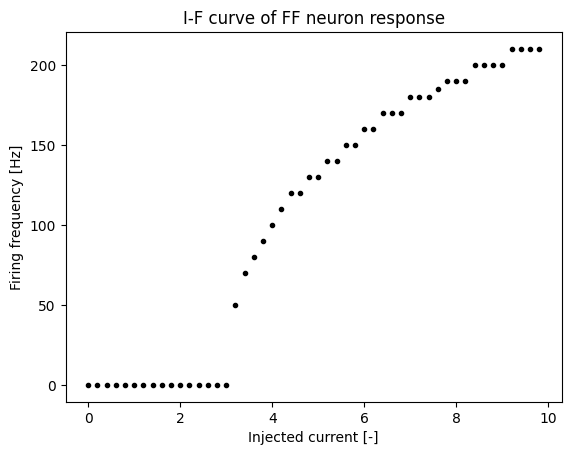

In [ ]:
I_vec=np.arange(0,10,0.2)
f_vec=[]
for j in I_vec:
  V_vec_HH,Time_vec, V_vec_FF,Spike_vec_FF=Sim_AudFF(-65,-65,param_Aud,param_ff,param_S,j)
  spikecount=0
  for k in Spike_vec_FF:
    spikecount=spikecount+k
  f_vec.append(1000*spikecount/Time_vec[-1])

plt.plot(I_vec,f_vec,'.k')
plt.xlabel('Injected current [-]')
plt.ylabel('Firing frequency [Hz]')
plt.title('I-F curve of FF neuron response')
plt.show()


Again, we can test what happens when we inject very large current values to test the limit behaviour of the model

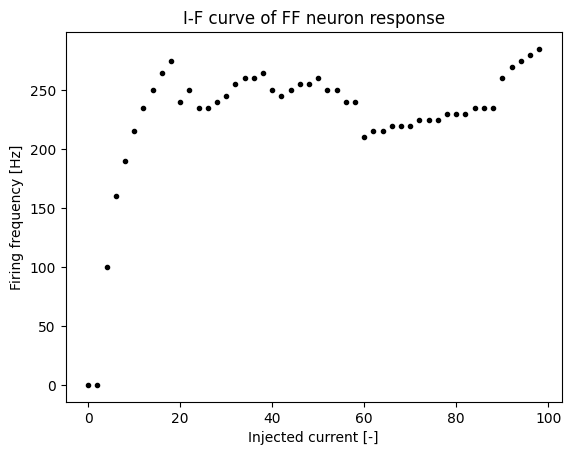

In [ ]:
I_vec=np.arange(0,100,2)
f_vec=[]
for j in I_vec:
  V_vec_HH,Time_vec, V_vec_FF,Spike_vec_FF=Sim_AudFF(-65,-65,param_Aud,param_ff,param_S,j)
  spikecount=0
  for k in Spike_vec_FF:
    spikecount=spikecount+k
  f_vec.append(1000*spikecount/Time_vec[-1])

plt.plot(I_vec,f_vec,'.k')
plt.xlabel('Injected current [-]')
plt.ylabel('Firing frequency [Hz]')
plt.title('I-F curve of FF neuron response')
plt.show()

We observe that the frequency of the response of the FF cell stabilizes aroung 250 Hz.



<font color='green'> Exercise <font>

We observe that the last graph is very irregular, why do you think that is?  How would you make it more regular?

### The partial network with auditory cells and FF cells

**NETWORK**

In the previous section, we investigated a system of  one auditory cell and only one FF cell.

Let's now take into account the network structure.

There are 30 auditory left neurons and 30 auditory right neurons.

There are 30 FF left neurons and 30 FF right neurons.

There are one to one gap connections between auditory neurons and ipsilateral FF neurons.

Furthermore, there are inhibitory connections from FF neurons to contralateral ff neurons. These lateral connections are essential for decision making.



In [ ]:
def HH_multi(Vinit,param_FF,param_Aud,param_S,n_L,n_R,I_L,I_R):
#This function computes the temporal response of a HH cell given a sinusoidal input
#INPUT Vinit, initial value of the simulation
#INPUT param, parameters of the HH cell
#INPUT param of the simulation
#INPUT n_L, n_R number of left and right auditory cells
#INPUT I_L, I_R amplitude of the left and right injected current
#INPUT freq, frequency of the injected current
#OUTPUT Time_vec, a vector containg the time points of the simulation
#OUTPUT V_vec_FFL, V_vec_FFR, arrays containing the membrane potential of FF neurons
#OUTPUT V_vec_HHL, V_vec_HHR,  arrays containing the membrane potential of auditory neurons
#OUTPUT Spike_vec_FFL,Spike_vec_FF, arrays containing the spike trains of FF neurons

#Initializing variables
  V_vec_FFL=np.zeros((n_L,param_S.Nstep))
  V_vec_FFR=np.zeros((n_R,param_S.Nstep))
  g_gly_L=np.zeros((n_R,param_S.Nstep))
  g_gly_R=np.zeros((n_R,param_S.Nstep))
  V_vec_HHL=np.zeros((n_L,param_S.Nstep))
  V_vec_HHR=np.zeros((n_R,param_S.Nstep))
  m_vec_L=np.zeros((n_L,param_S.Nstep))
  m_vec_R=np.zeros((n_R,param_S.Nstep))
  n_vec_L=np.zeros((n_L,param_S.Nstep))
  n_vec_R=np.zeros((n_R,param_S.Nstep))
  h_vec_L=np.zeros((n_L,param_S.Nstep))
  h_vec_R=np.zeros((n_R,param_S.Nstep))
  Spike_vec_FFL=np.zeros((n_L,param_S.Nstep))
  Spike_vec_FFR=np.zeros((n_R,param_S.Nstep))
  Time_vec=np.zeros(param_S.Nstep)

  for j in range(n_L):
    V_vec_FFL[j][0]=Vinit
    V_vec_HHL[j][0]=Vinit
  for j in range(n_R):
    V_vec_FFR[j][0]=Vinit
    V_vec_HHR[j][0]=Vinit

  delay=int(0.3/param_S.dt)

  for t in range(param_S.Nstep-1):
    Time_vec[t+1]=Time_vec[t]+param_S.dt
    #Updating the synaptic weights
    for j in range(n_L):
      g_gly_L[j][t+1]=g_gly_L[j][t]*(1-0.5*param_S.dt)
      if t>delay:
        for k in range(n_R):
          g_gly_L[j][t+1]=g_gly_L[j][t+1]+0.02*Spike_vec_FFR[k][t-delay]

    for j in range(n_R):
      g_gly_R[j][t+1]=g_gly_R[j][t]*(1-0.5*param_S.dt)
      if t>delay:
        for k in range(n_L):
          g_gly_R[j][t+1]=g_gly_R[j][t+1]+0.02*Spike_vec_FFL[k][t-delay]

    #updating left cells
    for j in range(n_L):
      Igap=0.005*(V_vec_HHL[j][t]-V_vec_FFL[j][t])
      dV, dm, dn, dh=HH_main(V_vec_HHL[j][t],m_vec_L[j][t],n_vec_L[j][t],h_vec_L[j][t],param_Aud,I_L-Igap)
      V_vec_HHL[j][t+1]=V_vec_HHL[j][t]+param_S.dt*dV
      m_vec_L[j][t+1]=m_vec_L[j][t]+param_S.dt*dm
      n_vec_L[j][t+1]=n_vec_L[j][t]+param_S.dt*dn
      h_vec_L[j][t+1]=h_vec_L[j][t]+param_S.dt*dh
      Isyn=g_gly_L[j][t+1]*(-75-V_vec_FFL[j][t])
      V_vec_FFL[j][t+1],Spike_vec_FFL[j][t+1]=LIF_pot(V_vec_FFL[j][t],Igap+Isyn,param_FF,param_S)

    #updating right cells
    for j in range(n_R):
      Igap=0.005*(V_vec_HHR[j][t]-V_vec_FFR[j][t])
      dV, dm, dn, dh=HH_main(V_vec_HHR[j][t],m_vec_R[j][t],n_vec_R[j][t],h_vec_R[j][t],param_Aud,I_R-Igap)
      V_vec_HHR[j][t+1]=V_vec_HHR[j][t]+param_S.dt*dV
      m_vec_R[j][t+1]=m_vec_R[j][t]+param_S.dt*dm
      n_vec_R[j][t+1]=n_vec_R[j][t]+param_S.dt*dn
      h_vec_R[j][t+1]=h_vec_R[j][t]+param_S.dt*dh
      Isyn=g_gly_R[j][t+1]*(-75-V_vec_FFR[j][t])
      V_vec_FFR[j][t+1],Spike_vec_FFR[j][t+1]=LIF_pot(V_vec_FFR[j][t],Igap+Isyn,param_FF,param_S)

  return Time_vec,V_vec_FFL, V_vec_FFR,V_vec_HHL, V_vec_HHR, Spike_vec_FFL,Spike_vec_FFR

In [ ]:
n_L=5
n_R=10
I_L=5
I_R=20
Time_vec,V_vec_FFL, V_vec_FFR,V_vec_HHL, V_vec_HHR, Spike_vec_FFL,Spike_vec_FFR=HH_multi(-65,param_ff, param_Aud,param_S,n_L,n_R,I_L,I_R)

Let's plot the results

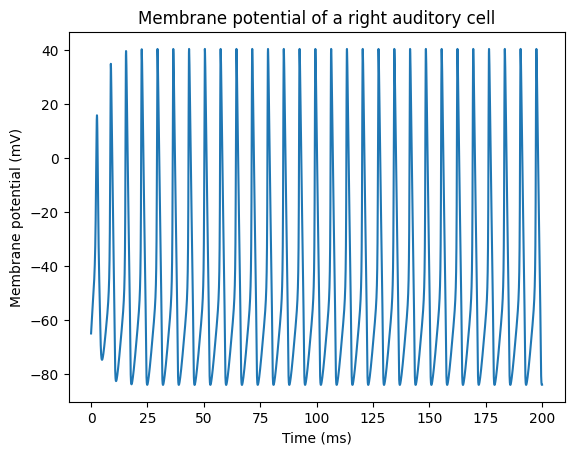

In [ ]:
plt.plot(Time_vec,V_vec_HHR[1])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Membrane potential of a right auditory cell')
plt.show()

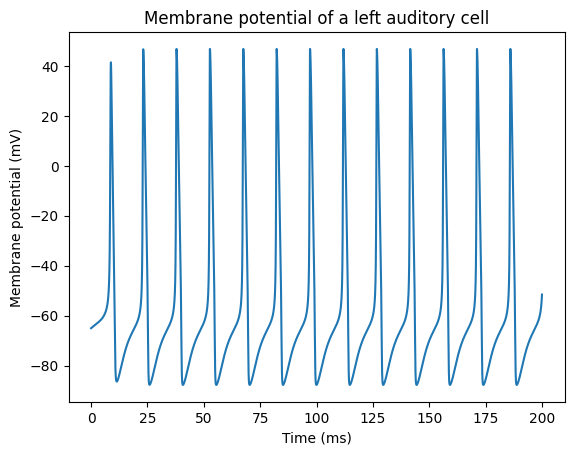

In [ ]:
plt.plot(Time_vec,V_vec_HHL[1])
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Membrane potential of a left auditory cell')
plt.show()

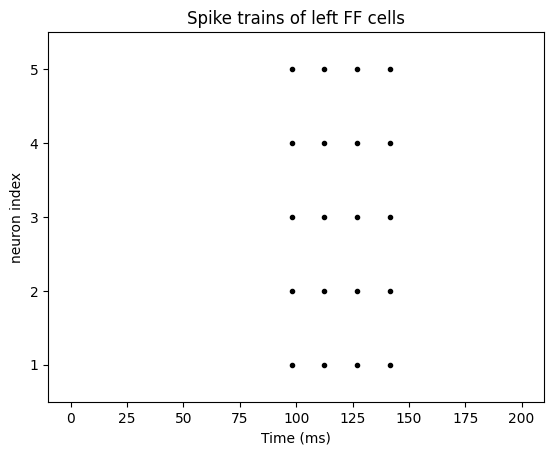

In [ ]:
for j in range(n_L):
  my_new_list = [i * (j+1) for i in Spike_vec_FFL[j]]
  plt.plot(Time_vec,my_new_list,'.k')
plt.ylim(0.5, n_L+0.5)
plt.ylabel('neuron index')
plt.xlabel('Time (ms)')
plt.title('Spike trains of left FF cells')
plt.show()

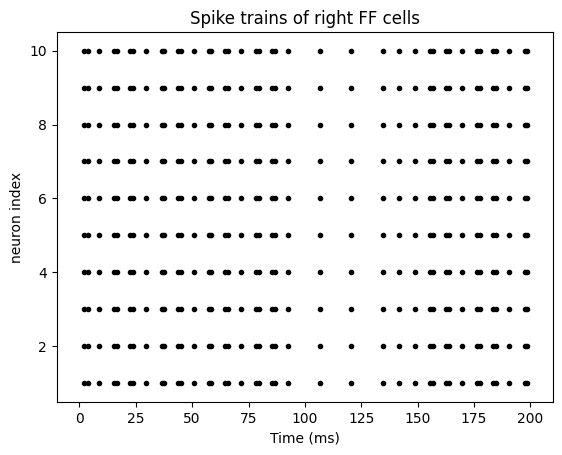

In [ ]:
for j in range(n_R):
  my_new_list = [i * (j+1) for i in Spike_vec_FFR[j]]
  plt.plot(Time_vec,my_new_list,'.k')

plt.ylim(0.5, n_R+0.5)
plt.xlabel('Time (ms)')
plt.ylabel('neuron index')
plt.title('Spike trains of right FF cells')
plt.show()

❓**Exercice**: Let's explore different values of input strengths and number of neurons ❓

###Modelling the response of Mauthner cells

Finally, we are  ready to compute the response of the Mauthner cells.

Mauthner cells are connected through gap junctions to auditory cells.  They also receive excitatory synaptic connections.  

Mauthner cells receive inhibitory synaptic connections from FF neurons these connections are stronger when they are contralateral than ipsilateral.

We define a function that allows to modify the strength of synaptic connections onto the Mauthner cells.

In [ ]:
def M_response(param_M,param_S,n_L,n_R,V_aud_L,V_aud_R,Spike_vecLff,Spike_vecRff,ggap,gglu,ggly):
  #This function computes the response of the M cells for a given activity pattern of Auditory cells and FF cells
  #INPUT, param_M, parameters of M cells
  #INPUT, param_S, parameters of the simulation
  #INPUT, n_L, n_R the number of left and right cells
  #INPUT, V_aud_L, V_aud_R, membrane potential of left and right auditory cells
  #INPUT, Spike_vecLff, Spike_vecRff, spike train of FF cells
  #OUTPUT, V_vec_LM, V_vec_LR, membrane potential of the left and right Mauthner cells
  #OUTPUT, Spike_vec_LM,Spike_vec_RM, spike trains of the left and right Mauthner cells

  V_vec_LM=np.zeros(param_S.Nstep)
  V_vec_RM=np.zeros(param_S.Nstep)
  Spike_vec_LM=np.zeros(param_S.Nstep)
  Spike_vec_RM=np.zeros(param_S.Nstep)
  g_gly_L=np.zeros(param_S.Nstep)
  g_gly_R=np.zeros(param_S.Nstep)
  g_glu_L=np.zeros(param_S.Nstep)
  g_glu_R=np.zeros(param_S.Nstep)
  Vinit=-65
  V_vec_LM[0]=Vinit
  V_vec_RM[0]=Vinit

  #Computing the spike trains of auditory cells
  Spike_vec_LHH=np.zeros((n_L,param_S.Nstep))
  Spike_vec_RHH=np.zeros((n_R,param_S.Nstep))

  for j in range(n_L):
    for t  in range(param_S.Nstep-1):
      if V_aud_L[j][t+1]>0:
        if V_aud_L[j][t]<0:
          Spike_vec_LHH[j][t]=1

  for j in range(n_R):
    for t  in range(param_S.Nstep-1):
      if V_aud_R[j][t+1]>0:
        if V_aud_R[j][t]<0:
          Spike_vec_RHH[j][t]=1

  #Computing the glutamate synaptic weight
  delay=int(0.7/param_S.dt)
  for t in range(param_S.Nstep-1):
    g_glu_L[t+1]=g_glu_L[t]*(1-0.5*param_S.dt)
    if t>delay:
      for j in range(n_L):
        g_glu_L[t+1]=g_glu_L[t+1]+gglu*0.02*Spike_vec_LHH[j][t-delay]

  for t in range(param_S.Nstep-1):
    g_glu_R[t+1]=g_glu_R[t]*(1-0.5*param_S.dt)
    if t>delay:
      for j in range(n_R):
        g_glu_R[t+1]=g_glu_R[t+1]+gglu*0.02*Spike_vec_RHH[j][t-delay]

  #Computing the glycine synaptic weight
  delay=int(0.3/param_S.dt)
  for t in range(param_S.Nstep-1):
    g_gly_L[t+1]=g_gly_L[t]*(1-0.5*param_S.dt)
    if t>delay:
      for j in range(n_L):
        g_gly_L[t+1]=g_gly_L[t+1]+0.02*ggly*Spike_vecLff[j][t-delay]
      for j in range(n_R):
        g_gly_L[t+1]=g_gly_L[t+1]+0.05*ggly*Spike_vecRff[j][t-delay]

  for t in range(param_S.Nstep-1):
    g_gly_R[t+1]=g_gly_R[t]*(1-0.5*param_S.dt)
    if t>delay:
      for j in range(n_R):
        g_gly_R[t+1]=g_gly_R[t+1]+0.02*ggly*Spike_vecRff[j][t-delay]
      for j in range(n_L):
        g_gly_R[t+1]=g_gly_R[t+1]+0.05*ggly*Spike_vecLff[j][t-delay]


  for t in range(param_S.Nstep-1):
  #Updating the state of the left Mauthner cell
    igapL=0
    for x in range(n_L):
      igapL=igapL+0.01*ggap*(V_aud_L[x][t]-V_vec_LM[t])
    igluL=g_glu_L[t+1]*(0-V_vec_LM[t])
    iglyL=g_gly_L[t+1]*(-75-V_vec_LM[t])
    Iinj=igapL+igluL+iglyL
    V_vec_LM[t+1],Spike_vec_LM[t+1]=LIF_pot(V_vec_LM[t],Iinj,param_M,param_S)

  #Updating the state of the right Mauthner cell
    igapR=0
    for x in range(n_L):
      igapR=igapR+0.01*ggap*(V_aud_R[x][t]-V_vec_RM[t])
    igluR=g_glu_R[t+1]*(0-V_vec_RM[t])
    iglyR=g_gly_R[t+1]*(-75-V_vec_RM[t])
    Iinj=igapR+igluR+iglyR
    V_vec_RM[t+1],Spike_vec_RM[t+1]=LIF_pot(V_vec_RM[t],Iinj,param_M,param_S)
  return V_vec_LM, V_vec_RM,Spike_vec_LM,Spike_vec_RM



Let's test this function with 'normal' synaptic strenght and a normal strength of gap junction connection.

In [ ]:
def plot_M_response(n_L,n_R,I_L,I_R,ggap,ggly,gglu):
  Time_vec,V_vec_FFL, V_vec_FFR,V_vec_HHL, V_vec_HHR, Spike_vec_FFL,Spike_vec_FFR=HH_multi(-65,param_ff, param_Aud,param_S,n_L,n_R,I_L,I_R)
  V_vec_LM, V_vec_RM,Spike_vec_LM,Spike_vec_RM=M_response(param_M,param_S,5,5,V_vec_HHL,V_vec_HHR,Spike_vec_FFL,Spike_vec_FFR,ggap,ggly,gglu)
  Spike_v_RM=[]
  for j in Spike_vec_RM:
    Spike_v_RM.append(2*j)
  plt.plot(Time_vec,Spike_vec_LM,'.b',Time_vec,Spike_v_RM,'.k')
  plt.xlabel('Time [ms]')
  plt.yticks([1,2])
  plt.legend(['Left M Cell','Right M Cell'])
  plt.ylim(0.5,2.5)
  plt.title('$I_{left}=$'+str(I_L)+', $I_{right}=$'+str(I_R))
  plt.show()


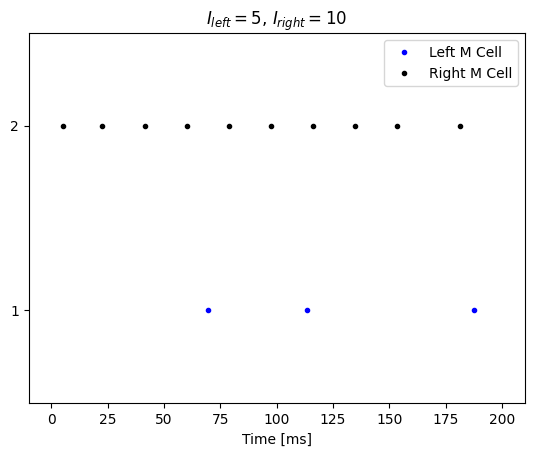

In [ ]:
n_L=10
n_R=10
I_L=5
I_R=10
ggap=1
ggly=1
gglu=1
plot_M_response(n_L,n_R,I_L,I_R,ggap,ggly,gglu)

**Exercice:**  Explore different conditions.

We observe that the response of the M cell on the side of the dominant input is much stronger than the response of the contralateral cell.   

We will now investigate how the response of M cells of each side depend on the input strength and on the strength of the inhibitory connections.

###Testing several cases

Now that the model is implemented we can use it to test how it responds to several scenarios.

-What is the impact of inhibition?

-What is the impact of contralateral input?

We begin by testing how the strength of inhibition shapes the response of Mauthner cells

In [ ]:
Time_vec,V_vec_FFL, V_vec_FFR,V_vec_HHL, V_vec_HHR, Spike_vec_FFL,Spike_vec_FFR=HH_multi(-65,param_ff, param_Aud,param_S,5,5,5,10)

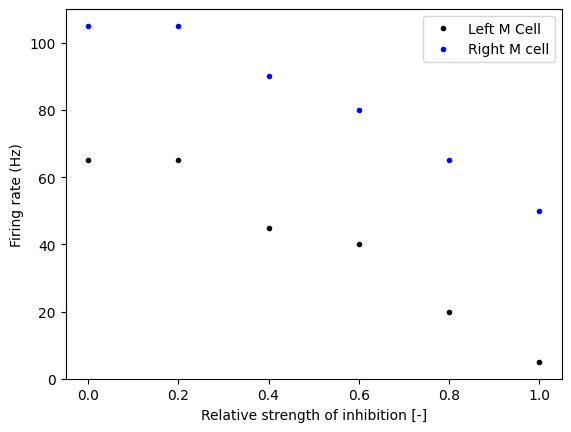

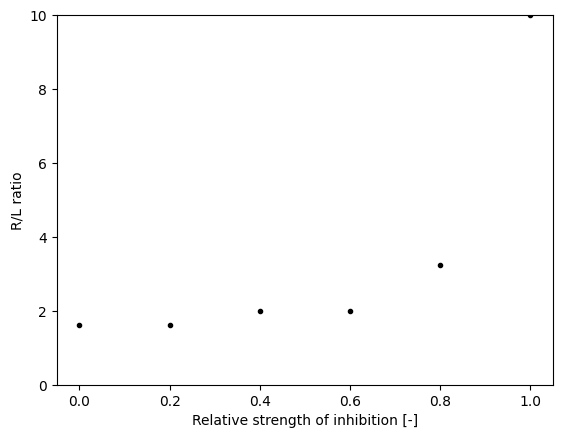

In [ ]:
gvec=np.arange(0,1.2,0.2)
Lfvec=[]
Rfvec=[]
ratio=[]
for j in gvec:
  V_vec_LM, V_vec_RM,Spike_vec_LM,Spike_vec_RM=M_response(param_M,param_S,5,5,V_vec_HHL,V_vec_HHR,Spike_vec_FFL,Spike_vec_FFR,1,1,j)
  spL=0
  spR=0
  for k in Spike_vec_LM:
    spL=spL+k
  for k in Spike_vec_RM:
    spR=spR+k
  Lfvec.append(1000*spL/Time_vec[-1])
  Rfvec.append(1000*spR/Time_vec[-1])
  ratio.append(spR/spL)

plt.plot(gvec,Lfvec,'.k',gvec,Rfvec,'.b')
plt.ylabel('Firing rate (Hz)')
plt.xlabel('Relative strength of inhibition [-]')
plt.legend(['Left M Cell', 'Right M cell'])
plt.show()

plt.plot(gvec,ratio,'.k')
plt.ylabel('R/L ratio')
plt.xlabel('Relative strength of inhibition [-]')
plt.ylim(0,10)
plt.show()



We see that inhibition increases the selective nature of the response.

One could ask whether a signal on one side affects the response of the contralateral Mauthner cell.

We repeat the experiment above but with the signal on a single side

We see that the contralateral M cells doesn't emit any spike.

We also observe that the response of the ipsilateral cell is the same as in the previous case.

We now test the case where the inputs on both side are equal

In [ ]:
Time_vec,V_vec_FFL, V_vec_FFR,V_vec_HHL, V_vec_HHR, Spike_vec_FFL,Spike_vec_FFR=HH_multi(-65,param_ff, param_Aud,param_S,5,5,10,10)

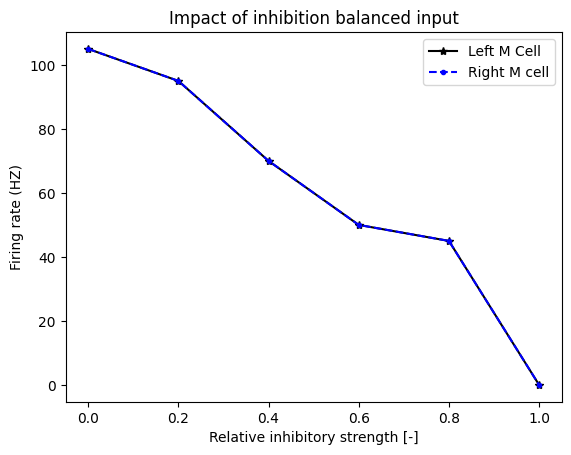

In [ ]:
gvec=np.arange(0,1.2,0.2)
Lfvec=[]
Rfvec=[]
ratio=[]
for j in gvec:
  V_vec_LM, V_vec_RM,Spike_vec_LM,Spike_vec_RM=M_response(param_M,param_S,5,5,V_vec_HHL,V_vec_HHR,Spike_vec_FFL,Spike_vec_FFR,1,1,j)
  spL=0
  spR=0
  for k in Spike_vec_LM:
    spL=spL+k
  for k in Spike_vec_RM:
    spR=spR+k
  Lfvec.append(1000*spL/Time_vec[-1])
  Rfvec.append(1000*spR/Time_vec[-1])

plt.plot(gvec,Lfvec,'-*k',gvec,Rfvec,'--.b')
plt.xlabel('Relative inhibitory strength [-]')
plt.ylabel('Firing rate (HZ)')
plt.legend(['Left M Cell', 'Right M cell'])
plt.title('Impact of inhibition balanced input')
plt.show()

We obtain the intuitive result that when inhibition is at its normal level, there is no directional response to stimuli of equal strength on each side.

Finally, we fix the strength of  inhibition to its normal value and vary the strength of the contralateral input.

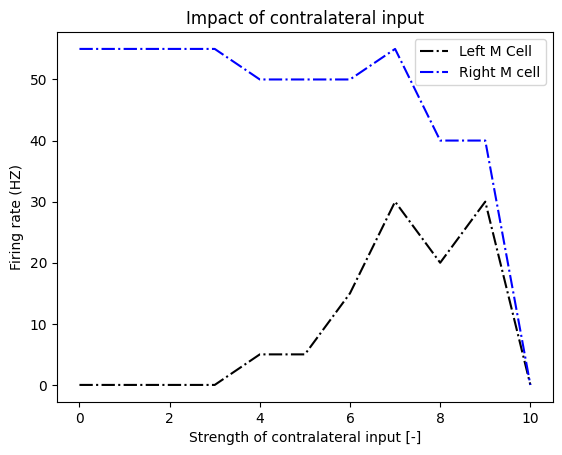

In [ ]:
I_vec=np.arange(0,11,1)
Lfvec=[]
Rfvec=[]
for j in I_vec:
  Time_vec,V_vec_FFL, V_vec_FFR,V_vec_HHL, V_vec_HHR, Spike_vec_FFL,Spike_vec_FFR=HH_multi(-65,param_ff, param_Aud,param_S,5,5,j,10)
  V_vec_LM, V_vec_RM,Spike_vec_LM,Spike_vec_RM=M_response(param_M,param_S,5,5,V_vec_HHL,V_vec_HHR,Spike_vec_FFL,Spike_vec_FFR,1,1,1)
  spL=0
  spR=0
  for k in Spike_vec_LM:
    spL=spL+k
  for k in Spike_vec_RM:
    spR=spR+k
  Lfvec.append(1000*spL/Time_vec[-1])
  Rfvec.append(1000*spR/Time_vec[-1])

plt.plot(I_vec,Lfvec,'-.k',I_vec,Rfvec,'-.b')
plt.xlabel('Strength of contralateral input [-]')
plt.ylabel('Firing rate (HZ)')
plt.legend(['Left M Cell', 'Right M cell'])
plt.title('Impact of contralateral input')
plt.show()

We observe that the response of the dominant side diminishes as the strength of the contralateral input is increased.  

This effect is very non linear.

### Sound localization

We won't go into details in the next paper, however, it reinforces that contralateral inhibitionis important in many sensory systems

ecka M, Zahn TP, Saunier-Rebori B, Siveke I, Felmy F, Wiegrebe L, Klug A, Pollak GD, Grothe B. Inhibiting the inhibition: a neuronal network for sound localization in reverberant environments. J Neurosci. 2007 Feb 14;27(7):1782-90.

The author present a circuit that allows for sound localization in rodents

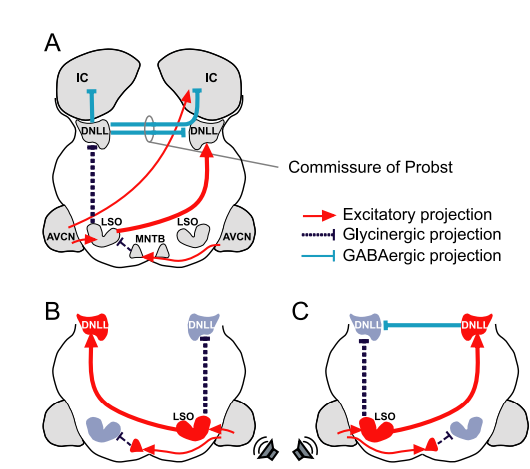

The following schematic is an excellent explanation

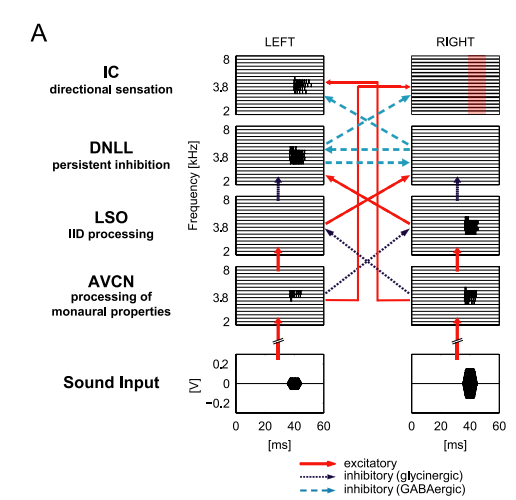

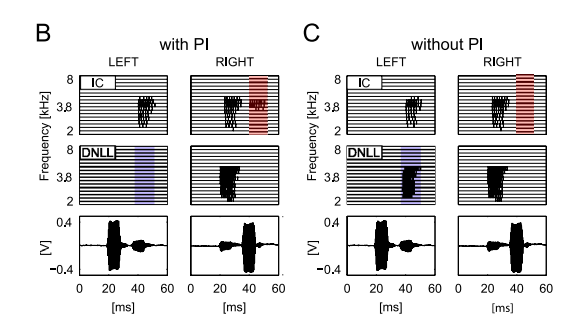

##  <font  color='brown'> Information propagation in feedforward networks <font>

Different types of neurons respond to different features of sensory signals.

Even a a feedforward network, different features of the sensory input can be transmitted to different actuators.

We present the model adapted from **A Brain-wide Circuit Model of Heat-Evoked Swimming Behavior in Larval Zebrafish**, Haesemeyer et al. 2018

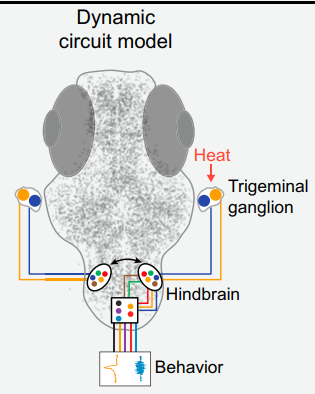

This model describes a neural network of your new favorite animal **the zebrafish** 🙂


This is a *population* model.

The model doesn't describe the activity of individual neurons rather the average activity of a group of neurons refered to as a population.

The populations of neurons included in the model are:

*   Trigeminal ON and OFF neurons,
*   RH 5/6 Slow ON and Slow OFF,
*   RH 5/6 Fast ON, Fast OFF, Delayed OFF,
*   Motor neurons: All, Flicks, Swims, EVK, SPNT.

In total, the model has 14 populations.

The model has a *feedforward* structure.

Trigeminal ▶ RH5/6 ▶ Motor▶ Swims/Flicks behaviour.

*Remark:* It was not possible to fully reproduce the results of the paper.

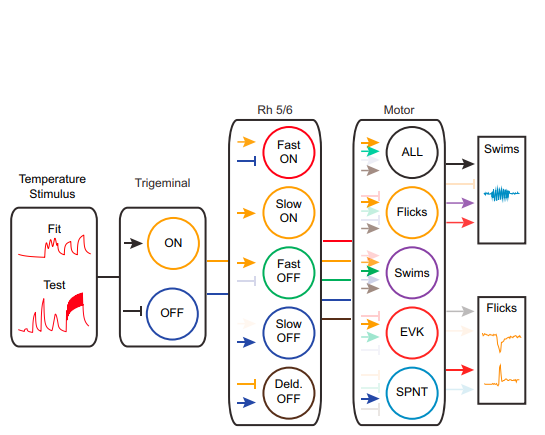

The feedforward structure allows to fit parameters layer by layer which is computationnaly tractable than having to perform a global fit. This reduces the dimensionality of the parameter space.

### Convolution

We begin by importing the necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets

We now generate a random noisy input representing the heat stimulus.

 We will generate a control signal without stimulation and then a signal to which we add a stimulus.

In [ ]:
def gen_CTRL_signal(b=10,c=0.3):
  Duration=1500
  dt =0.01

  sqdt=np.sqrt(dt)
  N=int(Duration/dt)
  T=np.linspace(0,Duration,N)
  signal=np.zeros(N)
  for i in range(N-1):
    a=rnd.random()-0.5
    signal[i+1]=signal[i]+b*a*sqdt
    signal[i+1]=signal[i+1]-c*dt*signal[i]

  return T,signal

Let's plot the result

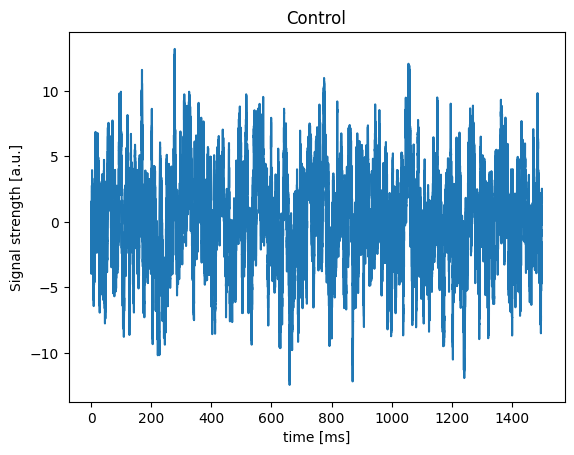

In [ ]:
Time, ctrl=gen_CTRL_signal()
plt.plot(Time,ctrl)
plt.xlabel('time [ms]')
plt.ylabel('Signal strength [a.u.]')
plt.title('Control')
plt.show()

**Questions**

Look at the code generating the signal:

❓ What is tbe impact of the paramaters $b$ and $c$ ❓

❓ Why do we use $\sqrt{dt}$ ❓

Let's now generate a signal with a heat evoked stimulus

In [ ]:
def gen_EVK_signal(b=10, c=0.3):
  Duration=150
  dt =0.01
  sqdt=np.sqrt(dt)
  N=int(Duration/dt)
  b=10
  c=0.3
  onset=50
  offset=70
  strength=5
  T=np.linspace(0,Duration,N)
  signal=np.zeros(N)
  for i in range(N-1):
    a=rnd.random()-0.5
    signal[i+1]=signal[i]+b*a*sqdt
    signal[i+1]=signal[i+1]-c*dt*signal[i]
    if T[i]>onset and T[i]<offset:
      signal[i+1]=signal[i+1]+strength*dt

  return T,signal

and plot the results...

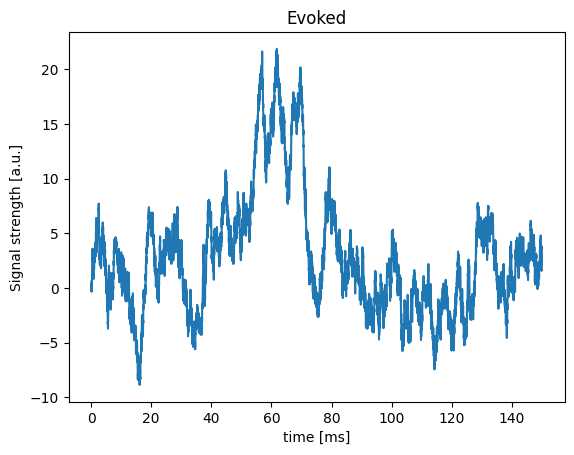

In [ ]:
Time,EVK=gen_EVK_signal()
plt.plot(Time,EVK)
plt.xlabel('time [ms]')
plt.ylabel('Signal strength [a.u.]')
plt.title('Evoked')
plt.show()

The sensory cells don't respond instantaneously to the heat stimulus.

Instead, the response can be described by a convolution of a signal with a time dependant function.

We give an example of a convolution function that depends on a onset time constant $\tau_{on}$ and and an offset time constant $\tau_{off}$

In [ ]:
def convo(s,tau_on=1,tau_off=3):
  #This function returns the value of the convolution function
  #INPUT s delta time, a positive real number
  #INPUT tau_on, tau_off, positive real numbers
  #OUTPUT f a real number, the value of the convolution function
  f=math.exp(-s/tau_off)*(1-math.exp(-s/tau_on))
  return f

In [ ]:
def plot_convo(tau_on,tau_off):
  #This function plots the time course of the convolution function
  #INPUT, tau_on, tau_off positive real numbers,
  T=[]
  f_convo=[]
  for j in range(100):
    f_convo.append(convo(0.2*j,tau_on,tau_off))
    T.append(0.2*j)
  plt.plot(T,f_convo)
  plt.xlabel('Time [s]')
  plt.show()

In [ ]:
widgets.interact(plot_convo, tau_on=(0.1,5,0.1),tau_off=(0.1,5,0.1))

interactive(children=(FloatSlider(value=2.5000000000000004, description='tau_on', max=5.0, min=0.1), FloatSlid…

<function __main__.plot_convo(tau_on, tau_off)>

With this, we can compute the convoluted response

In [ ]:
def Conv_response(Signal,Time,tau_on,tau_off):
  #This function computes the convolution between the signal and the convolution function of cell responses
  #INPUT: Signal, a list of real numbers containing the strength of the signal
  #INPUT: Time, a liste of real numbers containing the time points of the signal
  #INPUT: tau_on, tau_off, positive real numbers, parameters of the convolution function
  dt=Time[1]-Time[0]
  span=int(20/dt)
  Conv_resp=[]
  for j in range(len(Time)):
    if j<span:
      sum=0
      for delt in range(j):
        sum=sum+Signal[j-delt]*convo(delt*dt,tau_on,tau_off)
      Conv_resp.append(sum)
    else:
      sum=0
      for delt in range(span):
        sum=sum+Signal[j-delt]*convo(delt*dt,tau_on,tau_off)
      Conv_resp.append(sum)
  return(Conv_resp)

Lets's plot the result

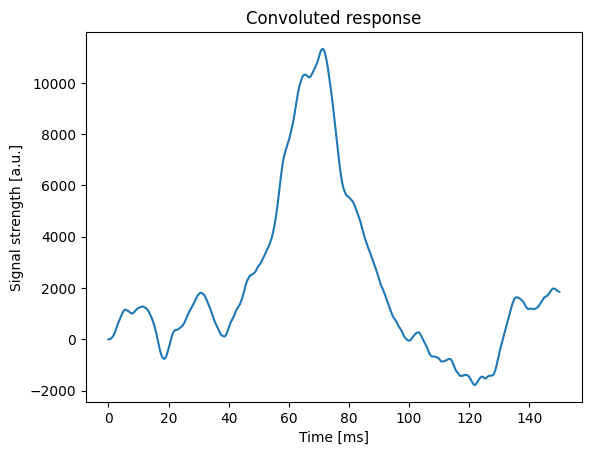

In [ ]:
Conv_resp=Conv_response(EVK,Time,1,10)
plt.plot(Time,Conv_resp)
plt.xlabel('Time [ms]')
plt.title('Convoluted response')
plt.ylabel('Signal strength [a.u.]')
plt.show()

An important concept of the paper is that even if the activity of all population ultimately result from the same stimulus, the activity of each population are decorrelated.


We now investigate whether and to what extent the convolution can decorrelate the signal and the response.

In [ ]:
def correl(A,B):
  #This function computes the correlation between to lists.
  #INPUT: A, B lists of real numbers,
  #OUTPUT: corr, the pearson correlation coefficients between A and B
  L=len(A)
  meanA=0
  meanB=0
  for j in range(L):
    meanA=meanA+A[j]
  meanA=meanA/L
  for j in range(L):
    meanB=meanB+B[j]
  meanB=meanB/L
  meanA2=0
  meanB2=0
  for j in range(L):
    meanA2=meanA2+A[j]*A[j]
  meanA2=meanA2/L
  for j in range(L):
    meanB2=meanB2+B[j]*B[j]
  meanB2=meanB2/L
  meanAB=0
  for j in range(L):
    meanAB=meanAB+A[j]*B[j]
  meanAB=meanAB/L
  varA=meanA2-meanA*meanA
  varB=meanB2-meanB*meanB
  covar=meanAB-meanA*meanB
  corr=covar/(math.sqrt(varA*varB))
  return corr

In [ ]:
correl(EVK,Conv_resp)

np.float64(0.6624465469011975)

We can test how the convolution parameters impact this decorrelation

In [ ]:
def decorrel(tau_on,tau_off,signal=EVK,Time=Time):
   Conv_resp=Conv_response(signal,Time,tau_on,tau_off)
   corr=correl(signal,Conv_resp)
   print(corr)

In [ ]:
tau_on=2
tau_off=6
decorrel(tau_on,tau_off)

0.6829010624534083


**Question**

❓What is the impact of the convolution parameters on the signal-response correlation ❓

We can observe that larger time constants lead to larger losses of correlation.

Neurons often respond on linearly. We can apply a sigmoid function to the convoluted response.

In [ ]:
def g(a):
  g=-0.2+1/(1+math.exp(-0.1*a+0.1))
  return g

Let's illustrate this function

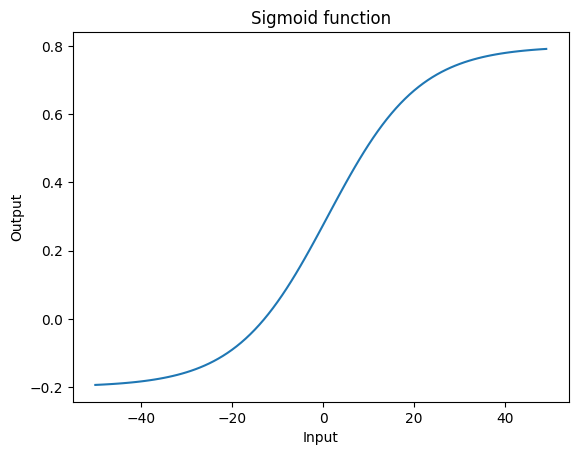

In [ ]:
inp=[]
Gresp=[]
for j in range(100):
  inp.append(-50+1*j)
  Gresp.append(g(inp[j]))
plt.plot(inp,Gresp)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Sigmoid function')
plt.show()

### Response of trigeminal cell populations

We now define a function describing the response of trigeminal cells

In [ ]:
def actiTrig(Inp_Vec,beta1,T,tau_on,tau_off):
  #This function computes the response of trigeminal cell populations
  #INPUT: Inp_Vec, a list of real number, the signal received
  #INPUT: T, a list of real numbers, time points of the signal
  #INPUT: tau_on, tau_off, positive real numbers, parameters of the convolution function
  dt=T[1]-T[0]
  span=int(20/dt)
  sum=0
  for j in range(span):
    sum=sum+convo(j*dt,tau_on,tau_off)
  A=[]
  for j in range(len(T)):
    inp=0
    if j<span:
      for delt in range(j):
        inp=inp+beta1*Inp_Vec[j-delt]*convo(delt*dt,tau_on,tau_off)/sum
      A.append(inp)
    else:
      for delt in range(span):
        inp=inp+beta1*Inp_Vec[j-delt]*convo(delt*dt,tau_on,tau_off)/sum
      A.append(inp)
  acti=[]
  for i in range(len(A)):
    acti.append(g(A[i]))
  return acti

Let's compute and plot the response of trigeminal ON cells

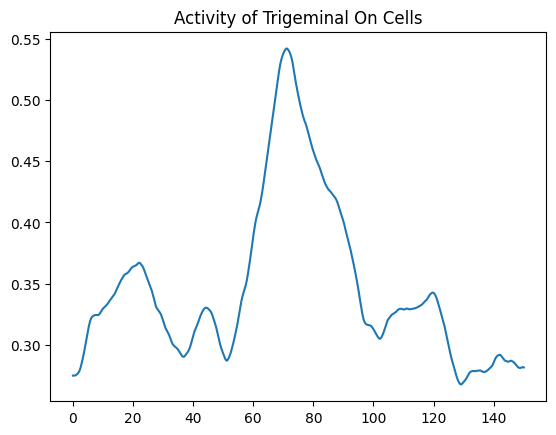

In [ ]:
Time, EVK=gen_EVK_signal()
beta1=0.7
tau_on=1
tau_off=10
acti_TrigOn=actiTrig(EVK,beta1,Time,tau_on,tau_off)
plt.plot(Time,acti_TrigOn)
plt.title('Activity of Trigeminal On Cells')
plt.show()

Let's compute and plot the response of trigeminal OFF cells

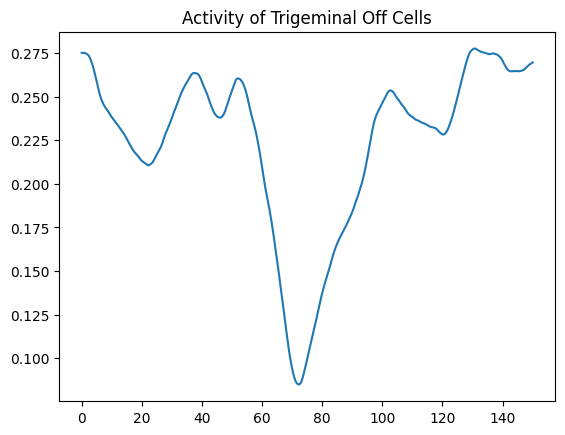

In [ ]:
beta1=-0.5
tau_on=5
tau_off=8
acti_TrigOff=actiTrig(EVK,beta1,Time,tau_on,tau_off)
plt.plot(Time,acti_TrigOff)
plt.title('Activity of Trigeminal Off Cells')
plt.show()

# Response of RH5/6 cell populations

We now move to describe the response of cell populations in RH5/6 layers

The convolution function proposed by the authors for RH5/6 cell populations has a different form.

The parameters of this convolution function are different from populations to populations.

In the paper, these parameters are fitted with a MCMC approach.

The parameters we use here may differ from the ones used in the paper.

In [ ]:
def convo_RH(delt,s,tau_on,tau_off):
  #Convolution function for the response of RH5/5 cells
  #INPUT: delt, a positive real number, the time of the functions
  #INPUT: s, tau_on, tau_off, positive real numbers, parameters of the convolution function
  #OUTPUT: f, a real number the value of the convolution function
  f=s*delt*math.exp(-delt/tau_off)+(1-delt)*math.exp(-delt/tau_on)
  return f

In [ ]:
def plot_convo_RH(s,tau_on,tau_off):
  #This function plots the convolution of RH5/6 as a function of time
  #INPUT s, tau_on, tau_off, positive real numbers, parameters of the convolution functions
  T=[]
  f_convo=[]
  for j in range(100):
    f_convo.append(convo_RH(0.04*j,s,tau_on,tau_off))
    T.append(0.04*j)
  plt.plot(T,f_convo)
  plt.xlabel('Time [s]')
  plt.show()

**Question**

❓Investigate the impact of the parameters $s, \tau_{on}, \tau_{off}$ on the convolution function ❓

In [ ]:
widgets.interact(plot_convo_RH, s=(0,1,0.1),tau_on=(0.1,5,0.1),tau_off=(0.1,5,0.1))

interactive(children=(FloatSlider(value=0.0, description='s', max=1.0), FloatSlider(value=2.5000000000000004, …

<function __main__.plot_convo_RH(s, tau_on, tau_off)>

We now code a function that will compute the response of RH 5/6 cells

In [ ]:
def actiRH(Inp_on,Inp_off,T, beta_on, beta_off,tau_on,tau_off,s):
  #Computes the response of RH5/6 populations
  #INPUT, Inp_on, Inp_off, lists of real numbers, signals received from on and of cells
  delt=T[1]-T[0]
  span=int(4/delt)
  sum=0
  for j in range(span):
    sum=sum+convo_RH(j*delt,s,tau_on,tau_off)

  Stimulus=[]
  for j in range(len(T)):
    Stimulus.append(beta_on*Inp_on[j]+beta_off*Inp_off[j])

  A=[]
  for j in range(len(T)):
    inp=0
    if j<span:
      for k in range(j):
        inp=inp+Stimulus[j-k]*convo_RH(k*delt,s,tau_on,tau_off)/sum
      A.append(inp)
        #inp=inp+beta_on*Inp_on[j-k]*convo_RH(k*delt,s,tau_on,tau_off)/sum+beta_off*Inp_off[j-k]*convo_RH(k*delt,s,tau_on,tau_off)/sum
    else:
      inp=0
      for k in range(j):
        inp=inp+Stimulus[j-k]*convo_RH(k*delt,s,tau_on,tau_off)/sum
        #inp=inp+beta_on*Inp_on[j-k]*convo_RH(k*delt,s,tau_on,tau_off)/sum+beta_off*Inp_off[j-k]*convo_RH(k*delt,s,tau_on,tau_off)/sum
      A.append(inp)
  acti=[]
  for i in range(len(A)):
    acti.append(g(A[i]))
  return acti


We compute and plot the response of the Slow On cells

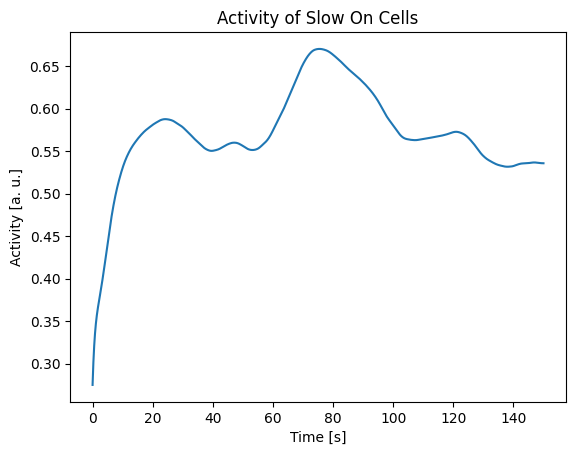

In [ ]:
beta_on=20
beta_off=0
tau_on=1.5
tau_off=2.5
s=0.5
acti_slowOn=actiRH(acti_TrigOn,acti_TrigOff,Time, beta_on, beta_off,tau_on,tau_off,s)
plt.plot(Time,acti_slowOn)
plt.title('Activity of Slow On Cells')
plt.xlabel('Time [s]')
plt.ylabel('Activity [a. u.]')
plt.show()

We compute and plot the response of the Slow Off cells

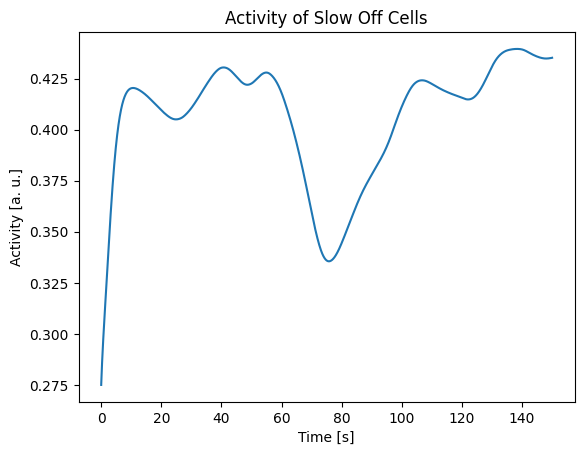

In [ ]:
tau_on=1
tau_off=2
s=1
beta_on=0
beta_off=15
acti_slowOff=actiRH(acti_TrigOn,acti_TrigOff,Time, beta_on, beta_off,tau_on,tau_off,s)
plt.plot(Time,acti_slowOff)
plt.title('Activity of Slow Off Cells')
plt.xlabel('Time [s]')
plt.ylabel('Activity [a. u.]')
plt.show()

We compute and plot the activity of the Fast ON cells

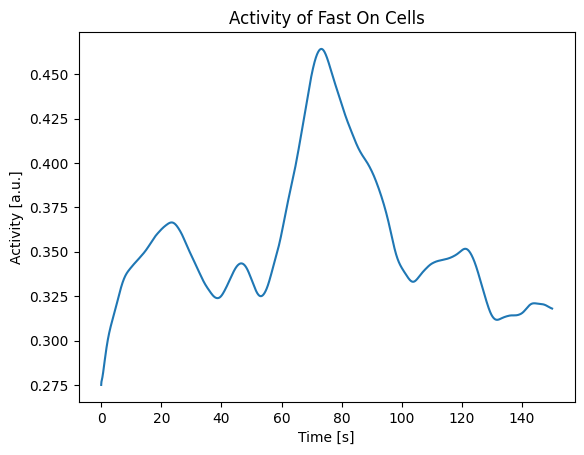

In [ ]:
tau_on=0.06
tau_off=1
s=1
beta_on=15
beta_off=-10
acti_fastOn=actiRH(acti_TrigOn,acti_TrigOff,Time, beta_on, beta_off,tau_on,tau_off,s)
plt.plot(Time,acti_fastOn)
plt.title('Activity of Fast On Cells')
plt.xlabel('Time [s]')
plt.ylabel('Activity [a.u.]')
plt.show()

We compute and plot the response of the Fast OFF cells

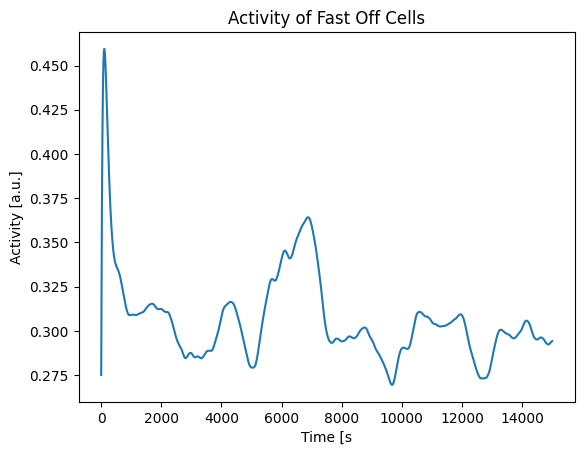

In [ ]:
tau_on=1
tau_off=0.2
s=1
beta_on=10
beta_off=-2
acti_fastOff=actiRH(acti_TrigOn,acti_TrigOff,Time, beta_on, beta_off,tau_on,tau_off,s)
plt.plot(acti_fastOff)
plt.title('Activity of Fast Off Cells')
plt.xlabel('Time [s]')
plt.ylabel('Activity [a.u.]')
plt.show()

We compute and plot the response of the Fast OFF cells

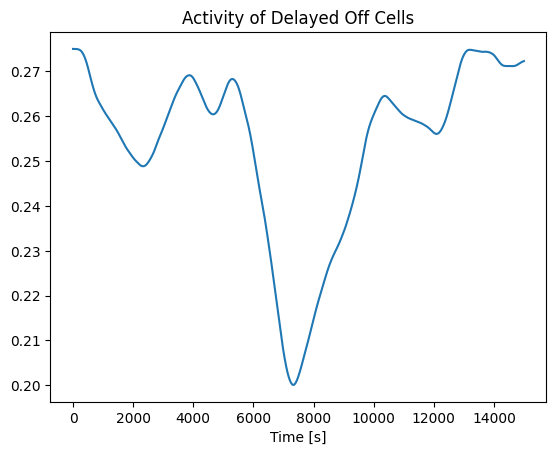

In [ ]:
tau_on=2
tau_off=2
s=1
beta_on=-6
beta_off=6

acti_DelOff=actiRH(acti_TrigOn,acti_TrigOff,Time, beta_on, beta_off,tau_on,tau_off,s)
plt.plot(acti_DelOff)
plt.title('Activity of Delayed Off Cells')
plt.xlabel('Time [s]')
plt.show()

We can now compute the correlation matrix of the different RH5/6 Neuron populations

[[ 1.         -0.31327253  0.84546047 -0.33345707 -0.81271081]
 [-0.31327253  1.         -0.71210642 -0.3967666   0.76448772]
 [ 0.84546047 -0.71210642  1.          0.09379758 -0.99651174]
 [-0.33345707 -0.3967666   0.09379758  1.          0.76448772]
 [-0.81271081  0.76448772 -0.99651174  0.76448772  1.        ]]


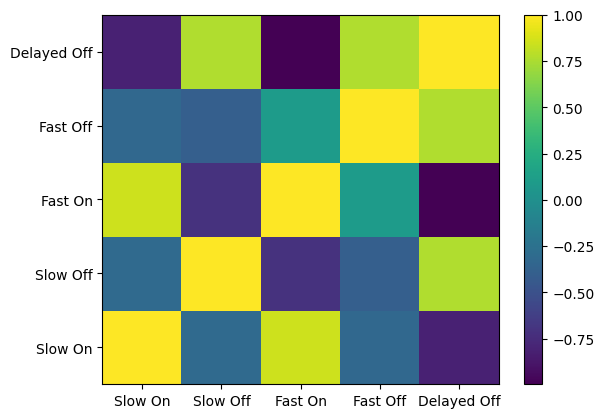

In [ ]:
correl_mat=np.zeros((5,5))
correl_mat[0,0]=1
correl_mat[0,1]=correl(acti_slowOn,acti_slowOff)
correl_mat[1,0]=correl_mat[0,1]
correl_mat[0,2]=correl(acti_slowOn,acti_fastOn)
correl_mat[2,0]=correl_mat[0,2]
correl_mat[0,3]=correl(acti_slowOn,acti_fastOff)
correl_mat[3,0]=correl_mat[0,3]
correl_mat[0,4]=correl(acti_slowOn,acti_DelOff)
correl_mat[4,0]=correl_mat[0,4]
correl_mat[1,1]=1
correl_mat[1,2]=correl(acti_slowOff,acti_fastOn)
correl_mat[2,1]=correl_mat[1,2]
correl_mat[1,3]=correl(acti_slowOff,acti_fastOff)
correl_mat[3,1]=correl_mat[1,3]
correl_mat[1,4]=correl(acti_slowOff,acti_DelOff)
correl_mat[4,1]=correl_mat[1,4]
correl_mat[2,2]=1
correl_mat[2,3]=correl(acti_fastOn,acti_fastOff)
correl_mat[3,2]=correl_mat[2,3]
correl_mat[2,4]=correl(acti_fastOn,acti_DelOff)
correl_mat[4,2]=correl_mat[2,4]
correl_mat[3,3]=1
correl_mat[3,4]=correl(acti_slowOff,acti_DelOff)
correl_mat[4,3]=correl_mat[3,4]
correl_mat[4,4]=1
print(correl_mat)
fig,ax = plt.subplots()
ax.pcolor(correl_mat)
ax.set_yticks(np.arange(5)+0.5)
ax.set_xticks(np.arange(5)+0.5)
fig.colorbar(ax.pcolor(correl_mat))

ax.set_yticklabels(['Slow On','Slow Off','Fast On','Fast Off','Delayed Off'])
ax.set_xticklabels(['Slow On','Slow Off','Fast On','Fast Off','Delayed Off'])
#ax.set_xticklabels(['Slow On','Slow Off','Fast On','Fast Off','Delayed Off'])
fig.show()

### Responses of the motor cell populations

The motor response is considered to be a linear combination of the input from the RH 5/6 layers, no convolution, no non linear transformation

In [ ]:
def MotorResp(FastOn,SlowOn,FastOff,SlowOff,DelOff,w,T):
  #Computes the response a motor cell population
  #FastOn, SlowOn, FastOff, SlowOff, DelOff, lists of real numbers
  acti=[]
  for j in range(len(T)):
    acti.append(w[0]*FastOn[j]+w[1]*SlowOn[j]+w[2]*FastOff[j]+w[3]*SlowOff[j]+w[4]*DelOff[j])
  return acti

Let's compute the response of the Motor All population

In [ ]:
#Computing the response of the Motor All population
w=[0.05,0.8,0.7,0.05, 0.5]
MotorAllActi=MotorResp(acti_fastOn,acti_slowOn,acti_fastOff,acti_slowOff,acti_DelOff,w,Time)

Let's compute the response of the Motor Flicks population

In [ ]:
#Computing the response of the Motor Flicks population
w=[-0.2,0.8,0.5,-0.1, 0.6]
MotorFlicksActi=MotorResp(acti_fastOn,acti_slowOn,acti_fastOff,acti_slowOff,acti_DelOff,w,Time)

Let's compute the response of the Motor Swims population

In [ ]:
#Computing the response of the Motor Swims population
w=[0.2,0.8,0.9,0.2, 0.6]
MotorSwimsActi=MotorResp(acti_fastOn,acti_slowOn,acti_fastOff,acti_slowOff,acti_DelOff,w,Time)

Let's compute the response of the Motor EVK population

In [ ]:
#Computing the response of the Motor Evoked population
w=[-0.1,0.7,0.5,-0.1, 0]
MotorEVkActi=MotorResp(acti_fastOn,acti_slowOn,acti_fastOff,acti_slowOff,acti_DelOff,w,Time)

Let's compute the response of the Motor SPNT population

In [ ]:
#Computing the response of the Motor SPNT population
w=[-0.1,-0.1,0.8,-0.1, 0]
MotorSPNTActi=MotorResp(acti_fastOn,acti_slowOn,acti_fastOff,acti_slowOff,acti_DelOff,w,Time)

In the paper, the Swims/Flicks behavioral responses are considered to be a linear combination of the activity of the motor populations

In [ ]:
def BehavResp(ALL,Flicks,Swims,EVK,SPNT,w,T):
  #Computes the behavioral response
  #INPUT: ALL, Flicks, Swims, EVK, SPNT, lists of real numbers, the activity of motor populations
  #INPUT: w a list of real numbers, the connection weights
  #INPUT: T, a list of real numbers, the time points of the input
  #OUTPUT: acti, a list of real numbers, the behavioral activity
  acti=[]
  for j in range(len(T)):
    acti.append(w[0]*ALL[j]+w[1]*Flicks[j]+w[2]*Swims[j]+w[3]*EVK[j]+w[4]*SPNT[j])
  return acti

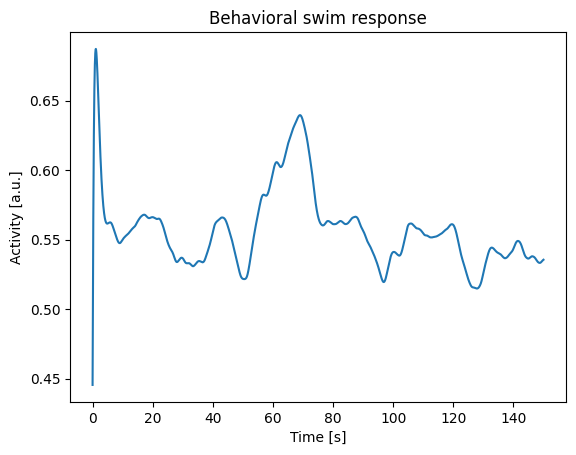

In [ ]:
w=[0,-0.1,0.4,0.2, 1]
BehavSwims=BehavResp(MotorAllActi,MotorFlicksActi,MotorSwimsActi,MotorEVkActi,MotorSPNTActi,w,Time)
plt.plot(Time,BehavSwims)
plt.xlabel('Time [s]')
plt.ylabel('Activity [a.u.]')
plt.title('Behavioral swim response')
plt.show()

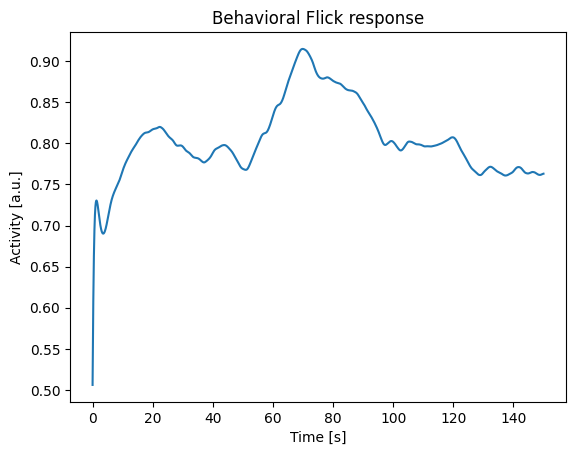

In [ ]:
w=[0.3,0.1,0,1, 0.1]
BehavFlicks=BehavResp(MotorAllActi,MotorFlicksActi,MotorSwimsActi,MotorEVkActi,MotorSPNTActi,w,Time)
plt.plot(Time,BehavFlicks)
plt.xlabel('Time [s]')
plt.ylabel('Activity [a.u.]')
plt.title('Behavioral Flick response')
plt.show()

We observe different response profiles for the swim and flick responses even if in the end both behaviours are triggered by the same stimulus.

### Mutual information

Shannon's entropy quantifies the information contained a a signal.  

The formula giving the entropy of a signal $X$ is

$H(X)=-\sum_p p\log (p)$.

**Question**

❓
 If a signal can take only two states, what is the probability distribution which maximes entropy
 ❓

 Mutual information between two signals computes the inforamtion that can be recovered on a signal from knowing the other.  It is given by

 $I(X,Y)=H(X)-H(X|Y)=H(Y)-H(Y|X)$.

 **Question**

❓
 If two signals $X$ and $Y$ are independant, what should be the mutual information?

 What is the mutual information between a signal and itself?

 ❓


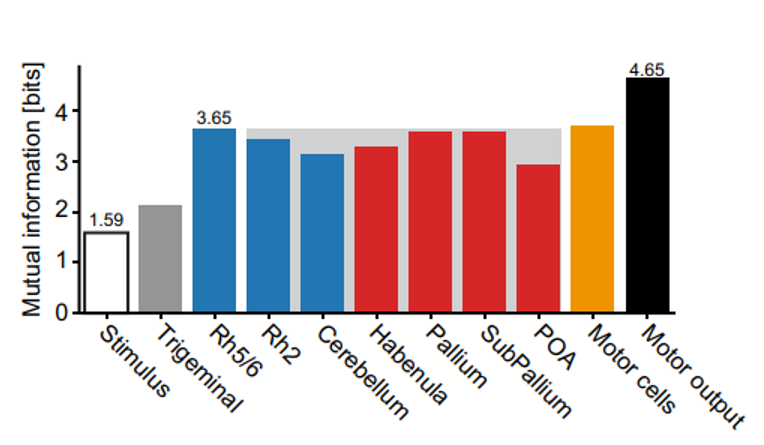

**Supplementary Exercice**

Write a code that computes the mutual information between the sensory signal and the motor response.